In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats
import pandas_profiling
import missingno as msno
import re
import datetime

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('./datasets/complete-df.csv')

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
profile = pandas_profiling.ProfileReport(df)
#Create an output file in the same folder as your notebook
profile.to_file(outputfile="df profiling.html")

In [5]:
profile

In [6]:
#note that customer_unique_id is the identifier for the same customer NOT customer_id
#initial drop: review_answer_timestamp, seller_zip_code_prefix, payment_sequential, review_creation_date, 

### Check Missing Values & Columns

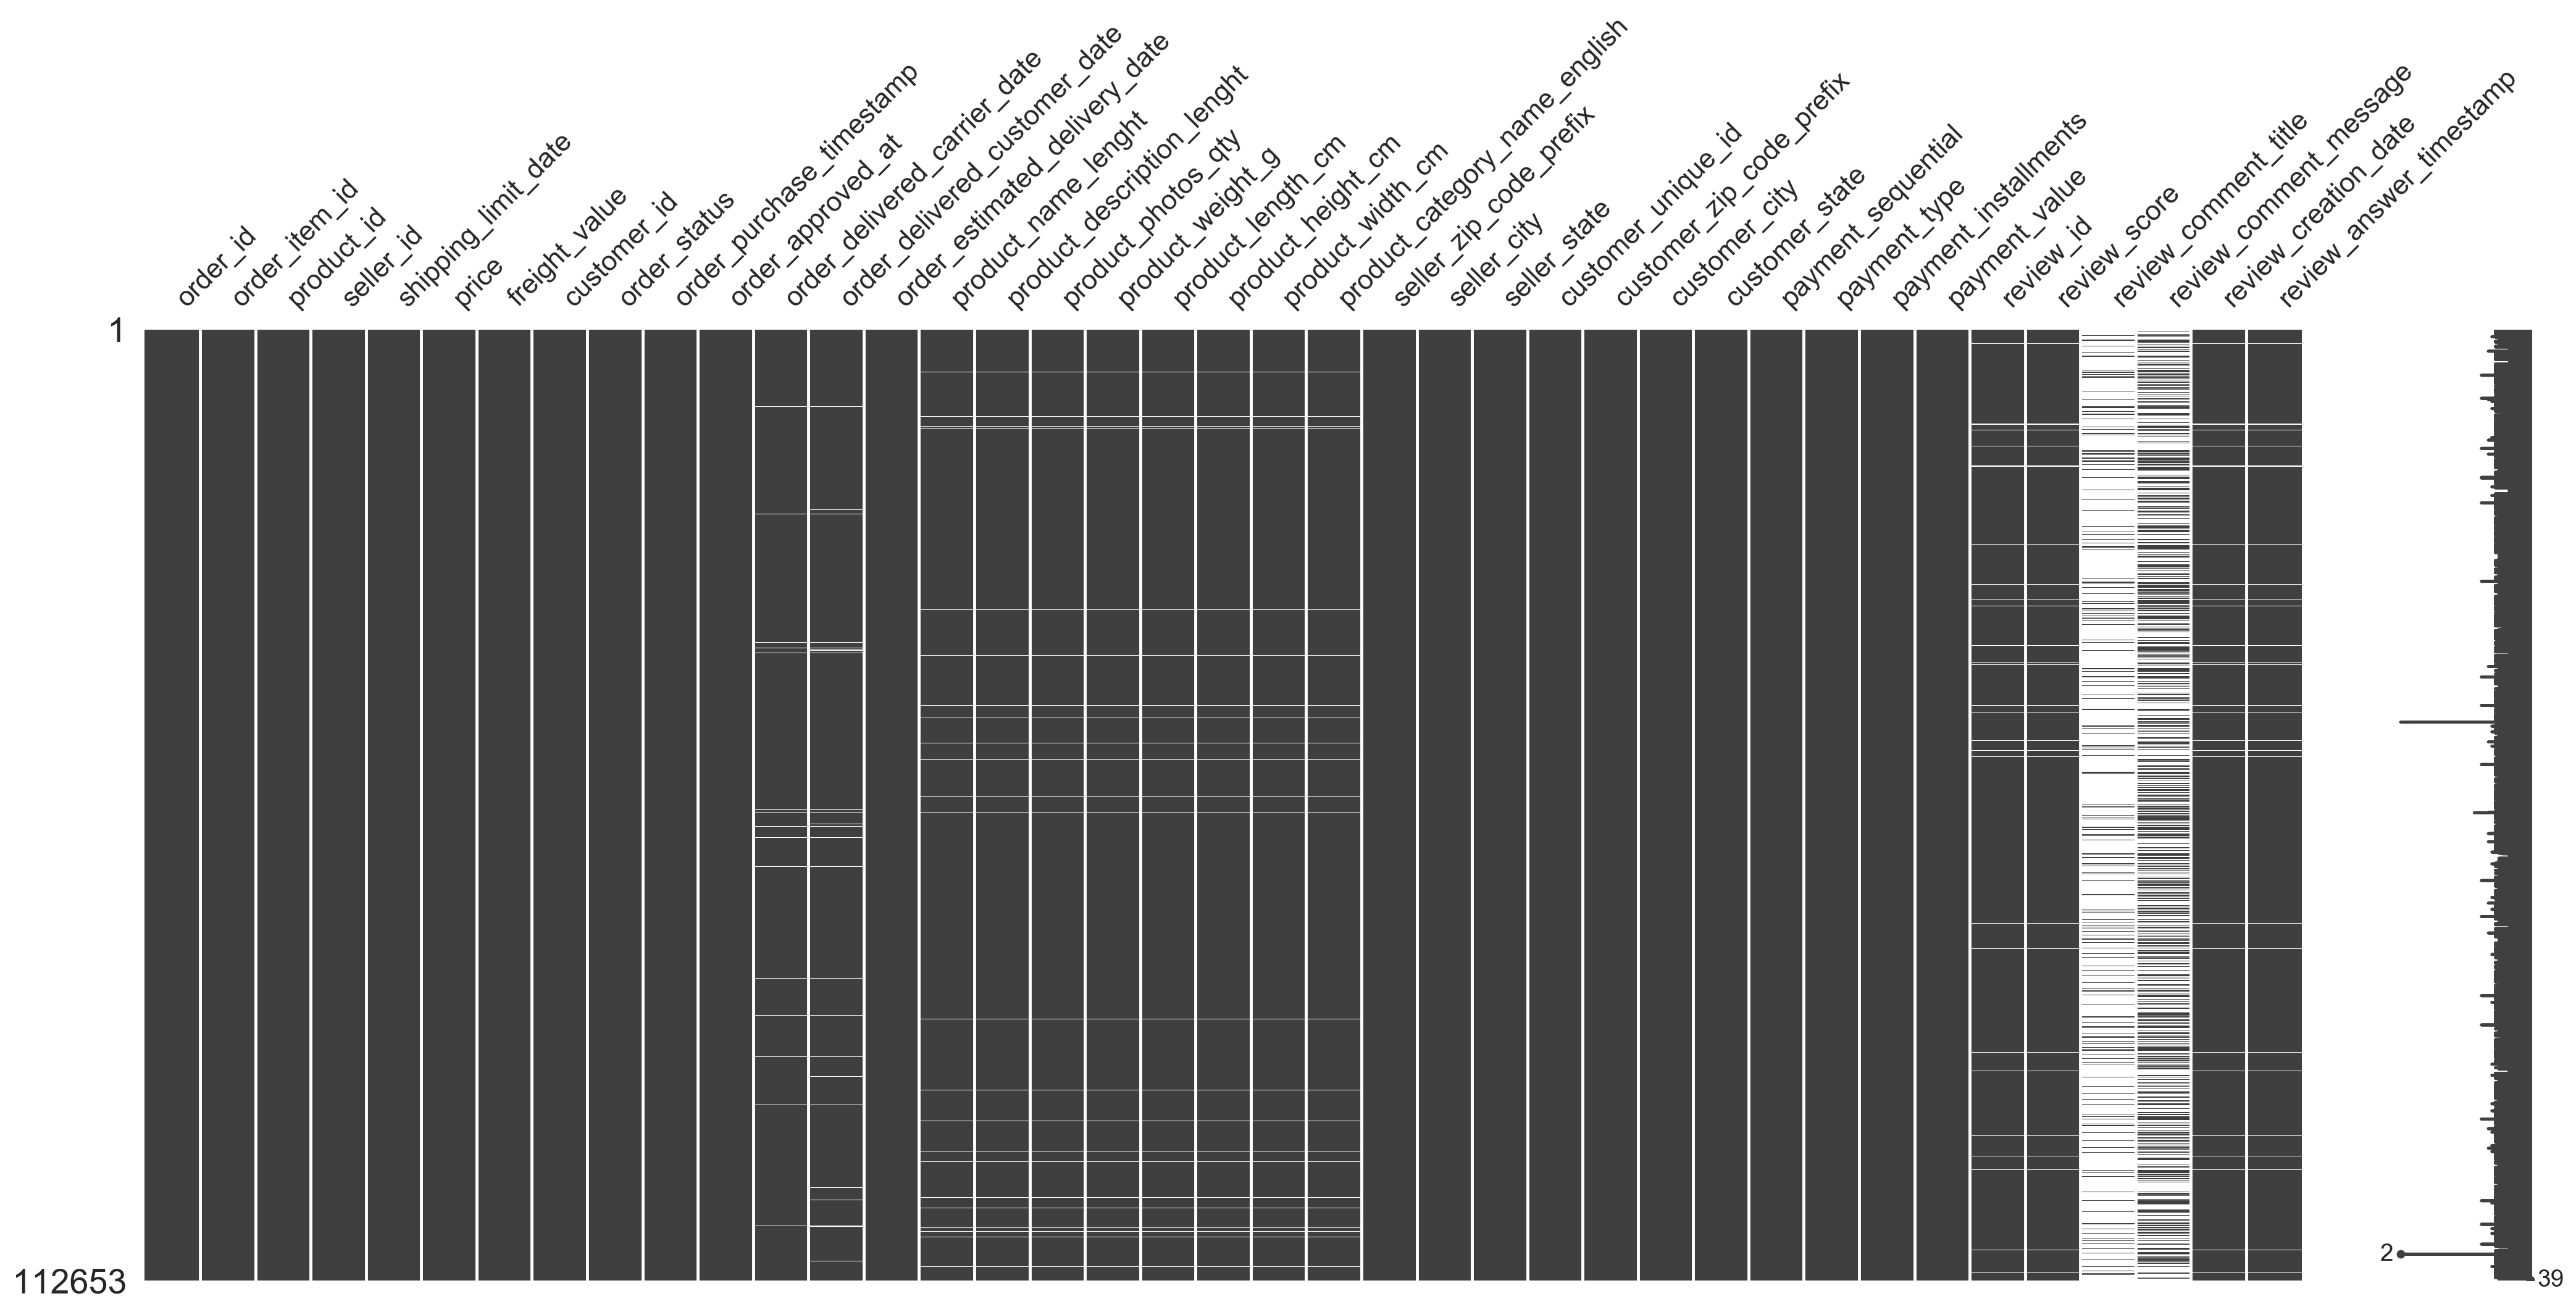

In [7]:
msno.matrix(df)

In [8]:
df.order_status.value_counts()

delivered      110197
shipped          1185
canceled          542
invoiced          359
processing        357
unavailable         7
approved            3
Name: order_status, dtype: int64

In [9]:
delivered_status = 110197/len(df.order_status)
print(delivered_status)

0.9781985388760175


##### Remove all order_status unless they have a delivered status (97.8%) 

In [10]:
df = df[df['order_status'] == 'delivered']

##### Dropping columns that will have no relevance to the final model as well as the two columns with majority missing values

In [11]:
df.drop(columns=['review_comment_title','review_comment_message','review_answer_timestamp', 'customer_id',
                 'seller_zip_code_prefix', 'payment_sequential', 'review_creation_date', 'order_approved_at',
                 'order_item_id', 'review_id','order_status'], inplace=True)

In [12]:
df.isnull().sum()

order_id                            0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
order_purchase_timestamp            0
order_delivered_carrier_date        2
order_delivered_customer_date       8
order_estimated_delivery_date       0
product_name_lenght              1559
product_description_lenght       1559
product_photos_qty               1559
product_weight_g                 1560
product_length_cm                1560
product_height_cm                1560
product_width_cm                 1560
product_category_name_english    1559
seller_city                         0
seller_state                        0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
payment_type                        3
payment_installments                3
payment_valu

##### Will definiteely need the review score and the product_category_name for all lines so I will drop all NAs 

In [13]:
df.dropna(subset = ['product_category_name_english','review_score'], axis=0, inplace = True)

In [14]:
df.shape

(107285, 28)

In [15]:
df.isnull().sum()

order_id                         0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
order_purchase_timestamp         0
order_delivered_carrier_date     2
order_delivered_customer_date    8
order_estimated_delivery_date    0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 1
product_length_cm                1
product_height_cm                1
product_width_cm                 1
product_category_name_english    0
seller_city                      0
seller_state                     0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
payment_type                     3
payment_installments             3
payment_value                    3
review_score                     0
dtype: int64

##### Only a few NAs left so I will drop them all

In [16]:
df.dropna(axis=0, inplace = True)

In [17]:
df.shape

(107272, 28)

##### Still over 100,000 lines of complete data so we are looking good

In [18]:
df.rename(columns = {'product_name_lenght': 'product_name_len',
                   'product_description_lenght': 'product_description_len'}, inplace=True)

### Check Datatypes

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107272 entries, 0 to 112652
Data columns (total 28 columns):
order_id                         107272 non-null object
product_id                       107272 non-null object
seller_id                        107272 non-null object
shipping_limit_date              107272 non-null object
price                            107272 non-null float64
freight_value                    107272 non-null float64
order_purchase_timestamp         107272 non-null object
order_delivered_carrier_date     107272 non-null object
order_delivered_customer_date    107272 non-null object
order_estimated_delivery_date    107272 non-null object
product_name_len                 107272 non-null float64
product_description_len          107272 non-null float64
product_photos_qty               107272 non-null float64
product_weight_g                 107272 non-null float64
product_length_cm                107272 non-null float64
product_height_cm                107272 no

##### Change to object: 
* customer_zip_code_prefix

In [20]:
df.customer_zip_code_prefix = df.customer_zip_code_prefix.astype('str')

##### Change to int64: 
* product_name_len
* product_description_len
* product_photos_qty
* payment_installments
* review_score 

In [21]:
def to_int(df, columns):
    """
       Takes a list of columns and changes them to int64
       
       Parameters:
       df
         pandas dataframe
         
       columns
         list of column names
      
       Returns:
       list
         a list of duplicate values 
        """
    for col in columns:
        df[col] = df[col].astype('int64')      

In [22]:
to_int(df, columns= ['product_name_len', 'product_description_len', 'product_photos_qty',
                     'payment_installments', 'review_score'])

##### Change to datetime : 
* shipping_limit_date
* order_purchase_timestamp
* order_delivered_carrier_date
* order_delivered_customer_date
* order_estimated_delivery_date 

In [23]:
def to_datetime(df, columns):
    """
       Takes a list of columns and changes them to datetime
       
       Parameters:
       df
         pandas dataframe
         
       columns
         list of column names
      
       Returns:
       list
         a list of duplicate values 
        """
    for col in columns:
        df[col] = pd.to_datetime(df[col])

In [24]:
to_datetime(df, columns = ['shipping_limit_date', 'order_purchase_timestamp', 'order_delivered_carrier_date',
                           'order_delivered_customer_date', 'order_estimated_delivery_date'])

In [25]:
df.dtypes

order_id                                 object
product_id                               object
seller_id                                object
shipping_limit_date              datetime64[ns]
price                                   float64
freight_value                           float64
order_purchase_timestamp         datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
product_name_len                          int64
product_description_len                   int64
product_photos_qty                        int64
product_weight_g                        float64
product_length_cm                       float64
product_height_cm                       float64
product_width_cm                        float64
product_category_name_english            object
seller_city                              object
seller_state                             object
customer_unique_id                      

In [26]:
df.head()

order_id                        product_id  \
0  00010242fe8c5a6d1ba2dd792cb16214  4244733e06e7ecb4970a6e2683c13e61   
1  00018f77f2f0320c557190d7a144bdd3  e5f2d52b802189ee658865ca93d83a8f   
2  000229ec398224ef6ca0657da4fc703e  c777355d18b72b67abbeef9df44fd0fd   
3  00024acbcdf0a6daa1e931b038114c75  7634da152a4610f1595efa32f14722fc   
4  00042b26cf59d7ce69dfabb4e55b4fd9  ac6c3623068f30de03045865e4e10089   

                          seller_id shipping_limit_date   price  \
0  48436dade18ac8b2bce089ec2a041202 2017-09-19 09:45:35   58.90   
1  dd7ddc04e1b6c2c614352b383efe2d36 2017-05-03 11:05:13  239.90   
2  5b51032eddd242adc84c38acab88f23d 2018-01-18 14:48:30  199.00   
3  9d7a1d34a5052409006425275ba1c2b4 2018-08-15 10:10:18   12.99   
4  df560393f3a51e74553ab94004ba5c87 2017-02-13 13:57:51  199.90   

   freight_value order_purchase_timestamp order_delivered_carrier_date  \
0          13.29      2017-09-13 08:59:02          2017-09-19 18:34:16   
1          19.93      2017-04-26 10:53:06          2017-05-04 14:35:00   
2          17.87      2018-01-14 14:33:31          2018-01-16 12:36:48   
3          12.79      2018-08-08 10:00:35          2018-08-10 13:28:00   
4          18.14      2017-02-04 13:57:51          2017-02-16 09:46:09   

  order_delivered_customer_date order_estimated_delivery_date  ...  \
0           2017-09-20 23:43:48                    2017-09-29  ...   
1           2017-05-12 16:04:24                    2017-05-15  ...   
2           2018-01-22 13:19:16                    2018-02-05  ...   
3           2018-08-14 13:32:39                    2018-08-20  ...   
4           2017-03-01 16:42:31                    2017-03-17  ...   

     seller_city  seller_state                customer_unique_id  \
0  volta redonda            SP  871766c5855e863f6eccc05f988b23cb   
1      sao paulo            SP  eb28e67c4c0b83846050ddfb8a35d051   
2  borda da mata            MG  3818d81c6709e39d06b2738a8d3a2474   
3         franca            SP  af861d436cfc08b2c2ddefd0ba074622   
4         loanda            PR  64b576fb70d441e8f1b2d7d446e483c5   

   customer_zip_code_prefix          customer_city  customer_state  \
0                   28013.0  campos dos goytacazes              RJ   
1                   15775.0        santa fe do sul              SP   
2                   35661.0          para de minas              MG   
3                   12952.0                atibaia              SP   
4                   13226.0        varzea paulista              SP   

   payment_type payment_installments payment_value review_score  
0   credit_card                    2         72.19            5  
1   credit_card                    3        259.83            4  
2   credit_card                    5        216.87            5  
3   credit_card                    2         25.78            4  
4   credit_card                    3        218.04            5  

[5 rows x 28 columns]

### Data Dictionary

Data dictionary created in excel for ease of use. 


In [27]:
data_dictionary = pd.read_csv('./Data Dictionary - Final df.csv')

In [28]:
data_dictionary

Variable        Datatype  \
0   order_id                                object   
1   product_id                              object   
2   seller_id                               object   
3   shipping_limit_date             datetime64[ns]   
4   price                                  float64   
5   freight_value                          float64   
6   order_purchase_timestamp        datetime64[ns]   
7   order_delivered_carrier_date    datetime64[ns]   
8   order_delivered_customer_date   datetime64[ns]   
9   order_estimated_delivery_date   datetime64[ns]   
10  product_name_len                         int64   
11  product_description_len                  int64   
12  product_photos_qty                       int64   
13  product_weight_g                       float64   
14  product_length_cm                      float64   
15  product_height_cm                      float64   
16  product_width_cm                       float64   
17  product_category_name_english           object   
18  seller_city                             object   
19  seller_state                            object   
20  customer_unique_id                      object   
21  customer_zip_code_prefix                object   
22  customer_city                           object   
23  customer_state                          object   
24  payment_type                            object   
25  payment_installments                     int64   
26  payment_value                          float64   
27  review_score                             int64   

                                          Description Variable Type  \
0                     unique id number for each order   categorical   
1                   unique id number for each product   categorical   
2                    unique id number for each seller   categorical   
3   seller shipping limit date for handling the or...    continuous   
4                                   price of the item      discrete   
5   item freight value item (if an order has more ...      discrete   
6                           time and date of purchase    continuous   
7                time and date of delivery to courier    continuous   
8               time and date of delivery to customer    continuous   
9   estimated delivery date given to customer at t...      discrete   
10  number of characters extracted from the produc...      discrete   
11  number of characters extracted from the produc...      discrete   
12                 number of product photos published      discrete   
13                                  weight of product    continuous   
14                                  length of product    continuous   
15                                  height of product    continuous   
16                                   width of product    continuous   
17        product category name translated to english   categorical   
18                               seller city location   categorical   
19                              seller state location   categorical   
20                 unique id number for each customer   categorical   
21      zip code prefix of customers delivery address   categorical   
22                             customer city location   categorical   
23                            customer state location   categorical   
24           method of payment chosen by the customer   categorical   
25      number of installments chosen by the customer      discrete   
26                                overall order value    continuous   
27  rating of 1 to 5 given by the customer on a sa...      discrete   

                               Example  
0   '00010242fe8c5a6d1ba2dd792cb16214'  
1   '4244733e06e7ecb4970a6e2683c13e61'  
2   '48436dade18ac8b2bce089ec2a041202'  
3                '2017-09-19 09:45:35'  
4                                 58.9  
5                                13.29  
6                '2017-09-13 08:59:02'  
7                '2017-09-19 18:34:16'  
8                '2017-09-20 2

### Explore Numerical Variables

In [29]:
data_dictionary[data_dictionary['Datatype'].isin(['int64','float64'])]

Variable Datatype  \
4   price                           float64   
5   freight_value                   float64   
10  product_name_len                  int64   
11  product_description_len           int64   
12  product_photos_qty                int64   
13  product_weight_g                float64   
14  product_length_cm               float64   
15  product_height_cm               float64   
16  product_width_cm                float64   
25  payment_installments              int64   
26  payment_value                   float64   
27  review_score                      int64   

                                          Description Variable Type Example  
4                                   price of the item      discrete    58.9  
5   item freight value item (if an order has more ...      discrete   13.29  
10  number of characters extracted from the produc...      discrete      58  
11  number of characters extracted from the produc...      discrete     598  
12                 number of product photos published      discrete       4  
13                                  weight of product    continuous     650  
14                                  length of product    continuous      28  
15                                  height of product    continuous       9  
16                                   width of product    continuous      14  
25      number of installments chosen by the customer      discrete       2  
26                                overall order value    continuous   72.19  
27  rating of 1 to 5 given by the customer on a sa...      discrete       5

In [30]:
df.describe().T

count         mean          std   min     25%  \
price                    107272.0   120.370412   182.529337  0.85   39.90   
freight_value            107272.0    19.994156    15.756007  0.00   13.08   
product_name_len         107272.0    48.799118    10.009362  5.00   42.00   
product_description_len  107272.0   789.208647   652.286343  4.00  348.00   
product_photos_qty       107272.0     2.216058     1.725992  1.00    1.00   
product_weight_g         107272.0  2097.386103  3746.359358  0.00  300.00   
product_length_cm        107272.0    30.179655    16.163498  7.00   18.00   
product_height_cm        107272.0    16.601219    13.441674  2.00    8.00   
product_width_cm         107272.0    23.011392    11.694892  6.00   15.00   
payment_installments     107272.0     2.977935     2.782918  0.00    1.00   
payment_value            107272.0   179.928471   272.598967  9.59   65.71   
review_score             107272.0     4.073272     1.353423  1.00    4.00   

                            50%      75%       max  
price                     74.90   134.90   6735.00  
freight_value             16.31    21.18    409.68  
product_name_len          52.00    57.00     76.00  
product_description_len  603.00   991.00   3992.00  
product_photos_qty         1.00     3.00     20.00  
product_weight_g         700.00  1800.00  40425.00  
product_length_cm         25.00    38.00    105.00  
product_height_cm         13.00    20.00    105.00  
product_width_cm          20.00    30.00    118.00  
payment_installments       2.00     4.00     24.00  
payment_value            114.43   195.50  13664.08  
review_score               5.00     5.00      5.00

##### Looking closer at the three variables of most interest

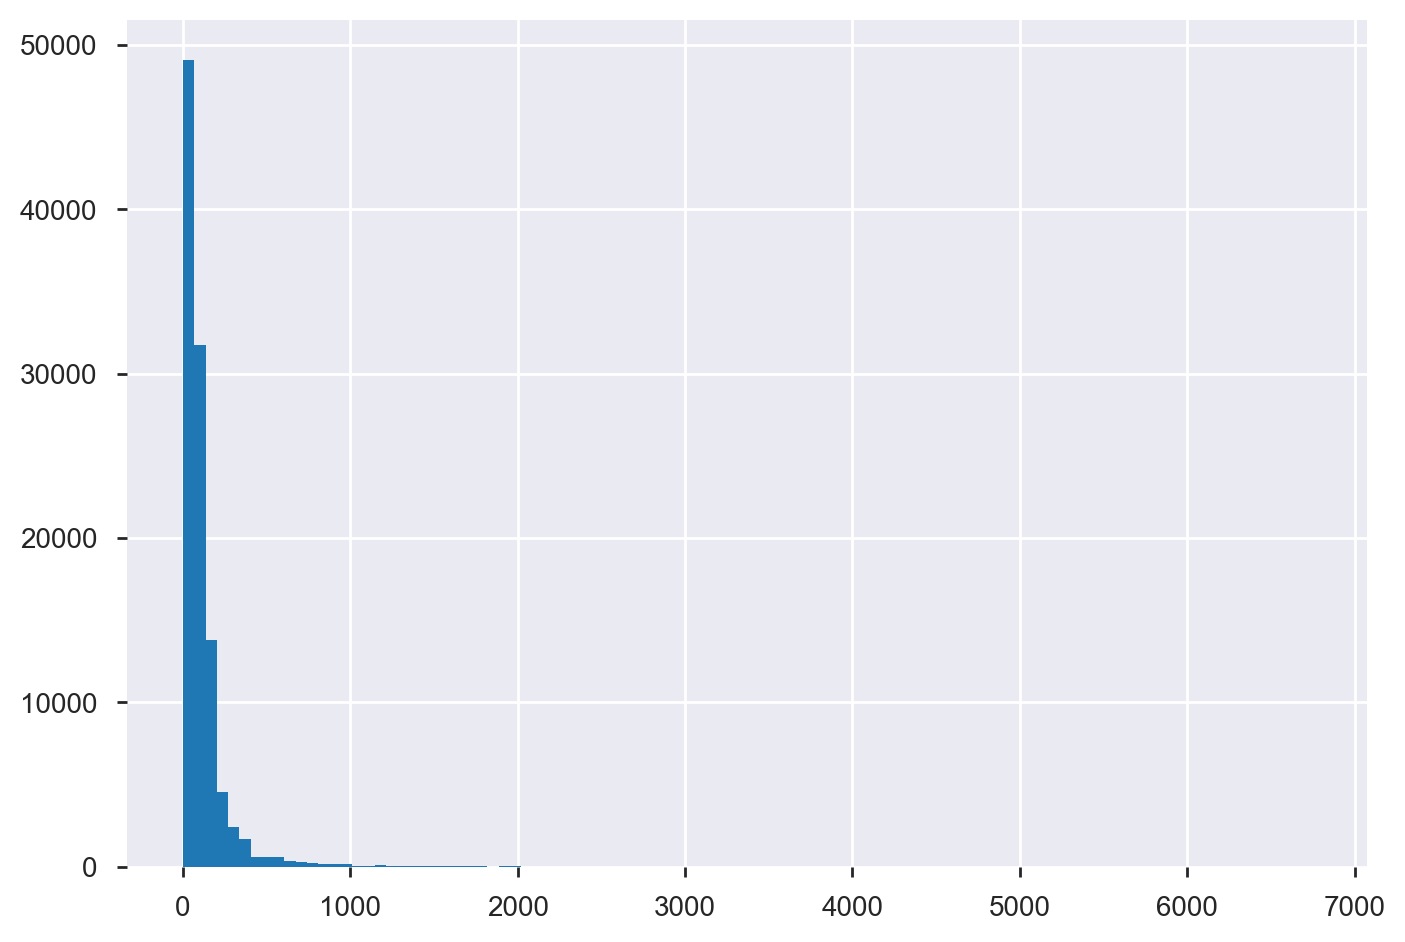

In [31]:
df.price.hist(bins = 100)

Text(0, 0.5, 'Frequency')

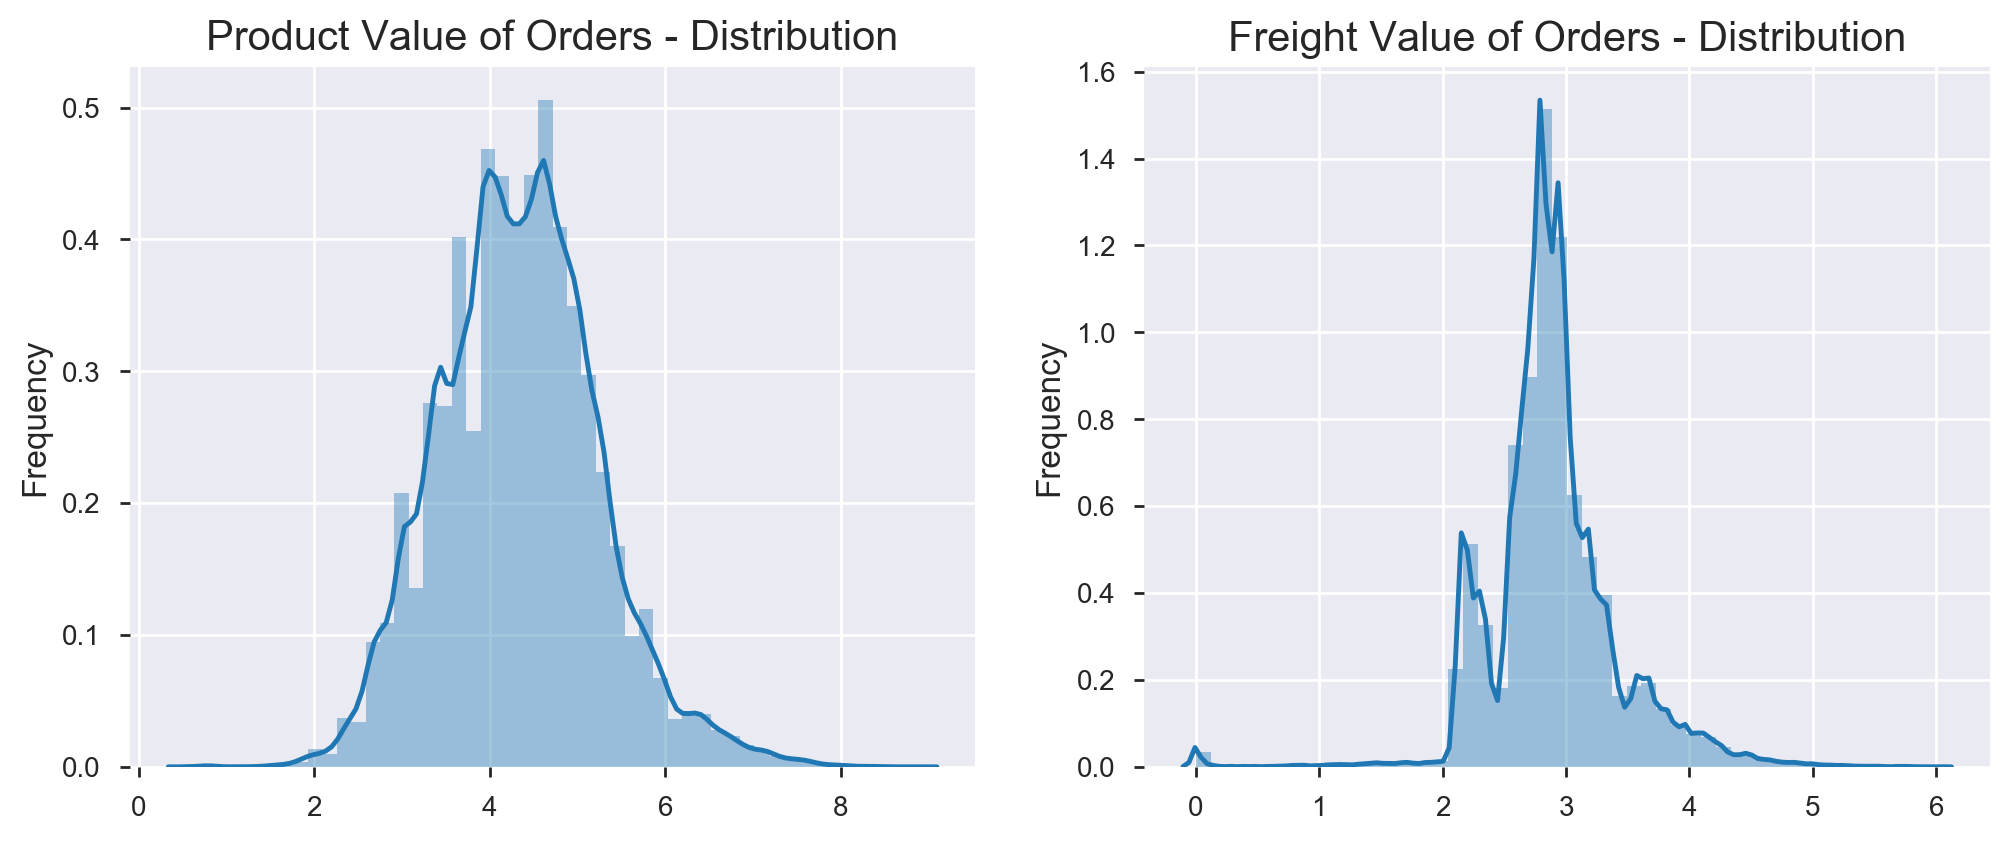

In [32]:
plt.figure(figsize=(12,10))

plt.subplot(221)
ax = sns.distplot(np.log(df['price'] + 1))
ax.set_title("Product Value of Orders - Distribution", fontsize=15)
ax.set_xlabel("")
ax.set_ylabel("Frequency", fontsize=12)

plt.subplot(222)
ax1 = sns.distplot(np.log(df['freight_value'] + 1))
ax1.set_title("Freight Value of Orders - Distribution", fontsize=15)
ax1.set_xlabel("")
ax1.set_ylabel("Frequency", fontsize=12)

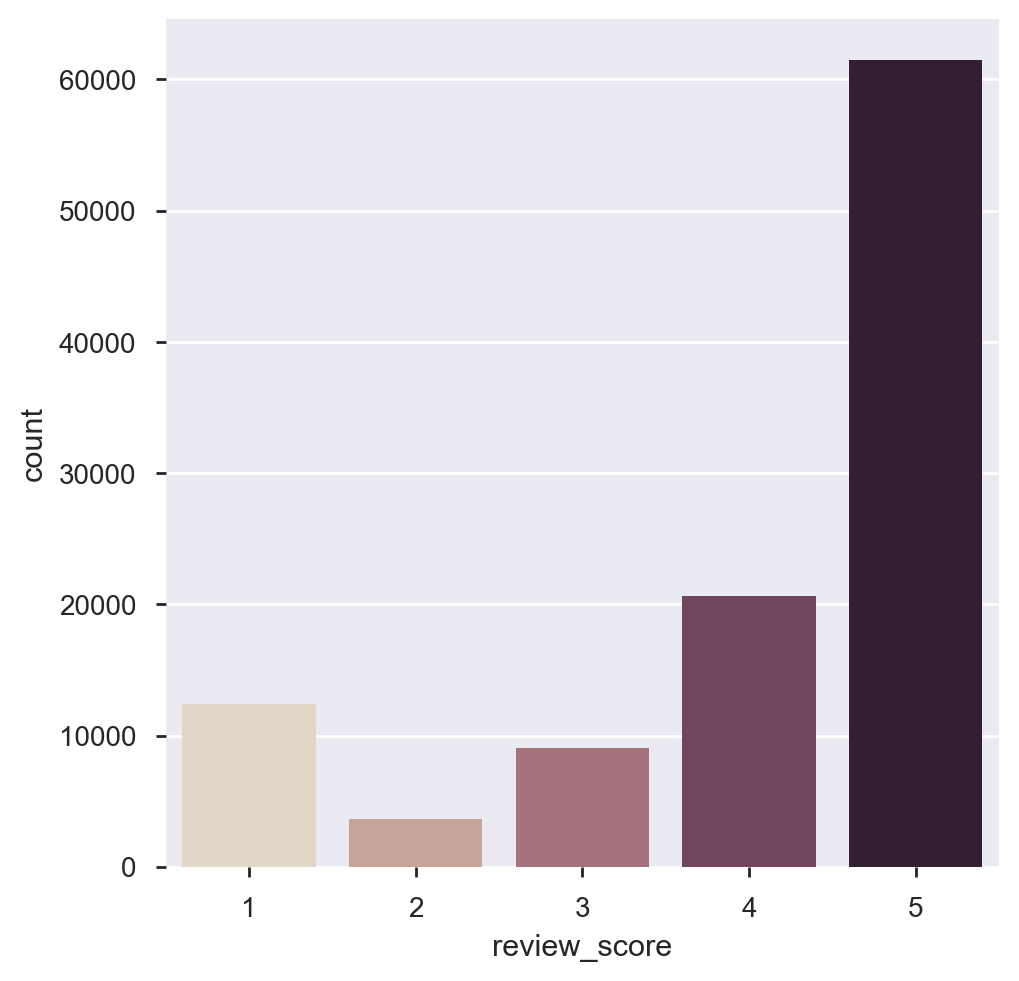

In [33]:
sns.catplot(data=df, x='review_score', kind="count", palette="ch:.25")

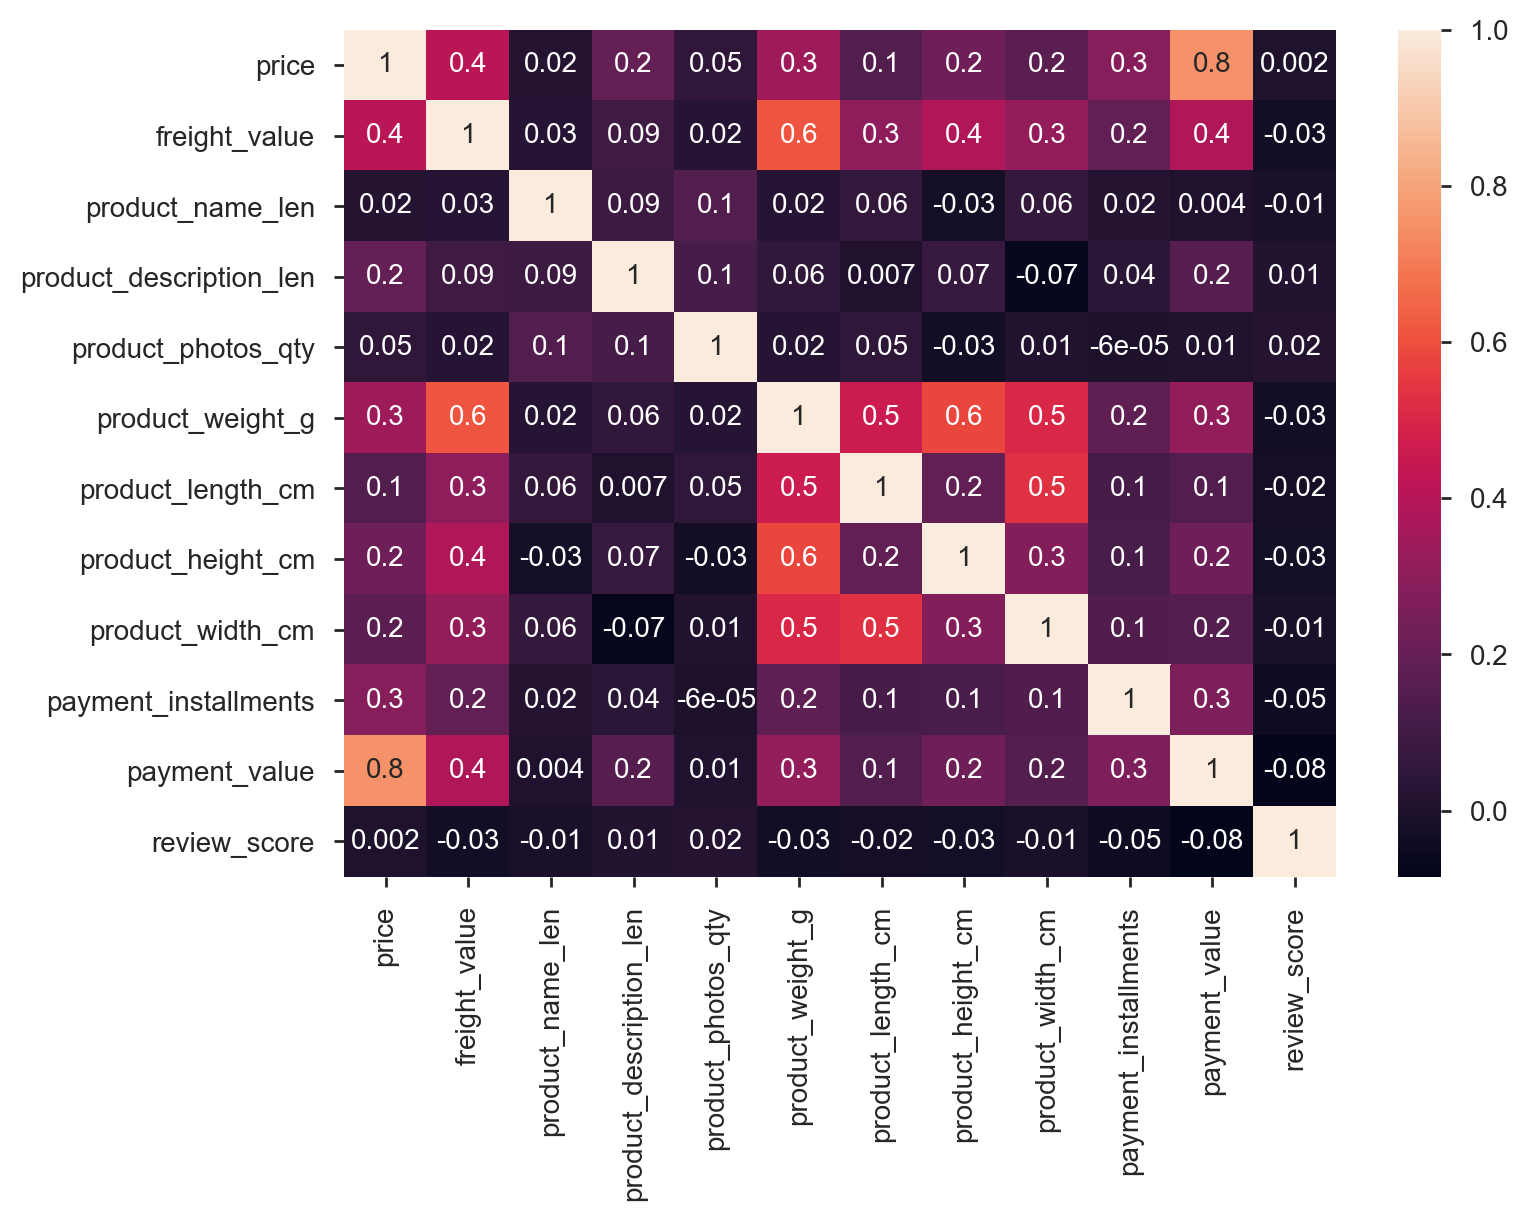

In [34]:
sns.heatmap(df.corr(), annot=True, fmt ='0.1g')

### Explore Time Variables

In [35]:
data_dictionary[data_dictionary['Datatype'] == 'datetime64[ns]']

Variable        Datatype  \
3  shipping_limit_date             datetime64[ns]   
6  order_purchase_timestamp        datetime64[ns]   
7  order_delivered_carrier_date    datetime64[ns]   
8  order_delivered_customer_date   datetime64[ns]   
9  order_estimated_delivery_date   datetime64[ns]   

                                         Description Variable Type  \
3  seller shipping limit date for handling the or...    continuous   
6                          time and date of purchase    continuous   
7               time and date of delivery to courier    continuous   
8              time and date of delivery to customer    continuous   
9  estimated delivery date given to customer at t...      discrete   

                 Example  
3  '2017-09-19 09:45:35'  
6  '2017-09-13 08:59:02'  
7  '2017-09-19 18:34:16'  
8  '2017-09-20 23:43:48'  
9  '2017-09-29 00:00:00'

##### Creation of new columns for purchase data

In [36]:
type(df['order_purchase_timestamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [37]:
df['order_purchase_year'] = df['order_purchase_timestamp'].apply(lambda x: x.year)


df['order_purchase_month'] = df['order_purchase_timestamp'].apply(lambda x: x.month)


df['order_purchase_dayofweek'] = df['order_purchase_timestamp'].apply(lambda x: x.dayofweek)

In [38]:
sales_by_month = df.groupby(['order_purchase_year','order_purchase_month'], as_index=False)['price'].sum()

In [39]:
sales_by_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 21
Data columns (total 3 columns):
order_purchase_year     22 non-null int64
order_purchase_month    22 non-null int64
price                   22 non-null float64
dtypes: float64(1), int64(2)
memory usage: 704.0 bytes


In [40]:
sales_by_month.loc[22] = [int(2016),11,0]

In [41]:
sales_by_month.dtypes

order_purchase_year       int64
order_purchase_month      int64
price                   float64
dtype: object

In [42]:
sales_by_month['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)

sales_by_month['month_year'] = sales_by_month['order_purchase_year'].astype(str) + '-' + sales_by_month['order_purchase_month'].astype(str)
    
sales_by_month['order_purchase_month'] = sales_by_month['order_purchase_month'].astype(int)


In [43]:
sales_by_month.sort_values(by=['order_purchase_year','order_purchase_month'],inplace=True)
sales_by_month.reset_index(drop=True,inplace=True)
sales_by_month

order_purchase_year  order_purchase_month      price month_year
0                  2016                    10   39732.54    2016-10
1                  2016                    11       0.00    2016-11
2                  2016                    12      10.90    2016-12
3                  2017                     1  105223.73     2017-1
4                  2017                     2  223860.00     2017-2
5                  2017                     3  348165.27     2017-3
6                  2017                     4  329794.52     2017-4
7                  2017                     5  471963.09     2017-5
8                  2017                     6  410648.50     2017-6
9                  2017                     7  471627.35     2017-7
10                 2017                     8  540094.50     2017-8
11                 2017                     9  593972.33     2017-9
12                 2017                    10  625832.56    2017-10
13                 2017                    11  962167.40    2017-11
14                 2017                    12  702486.03    2017-12
15                 2018                     1  893852.67     2018-1
16                 2018                     2  795390.97     2018-2
17                 2018                     3  928147.81     2018-3
18                 2018                     4  962412.90     2018-4
19                 2018                     5  971374.15     2018-5
20                 2018                     6  851195.87     2018-6
21                 2018                     7  852791.60     2018-7
22                 2018                     8  831630.11     2018-8

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

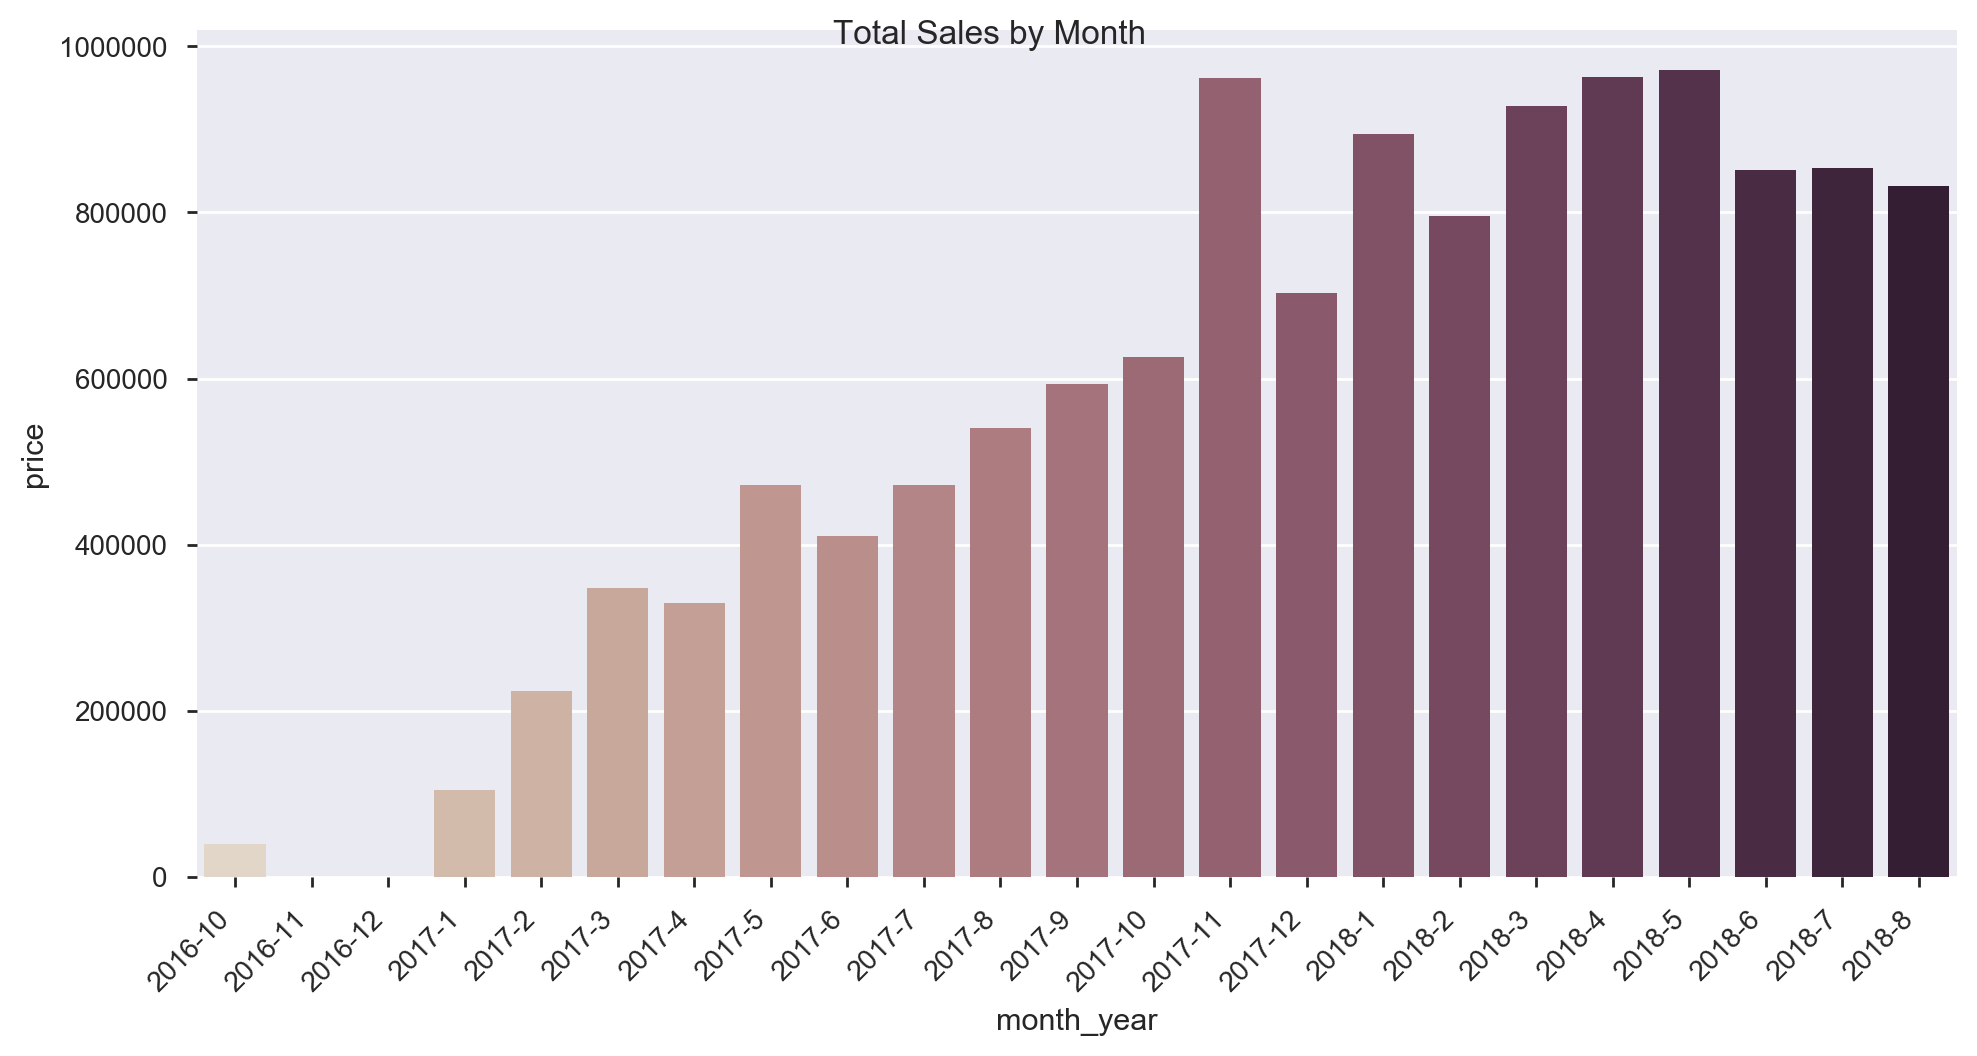

In [44]:
sns.catplot(data=sales_by_month, x='month_year', y='price', kind="bar", palette="ch:.25",aspect=2)
plt.suptitle("Total Sales by Month")
plt.xticks(rotation=45, horizontalalignment='right')

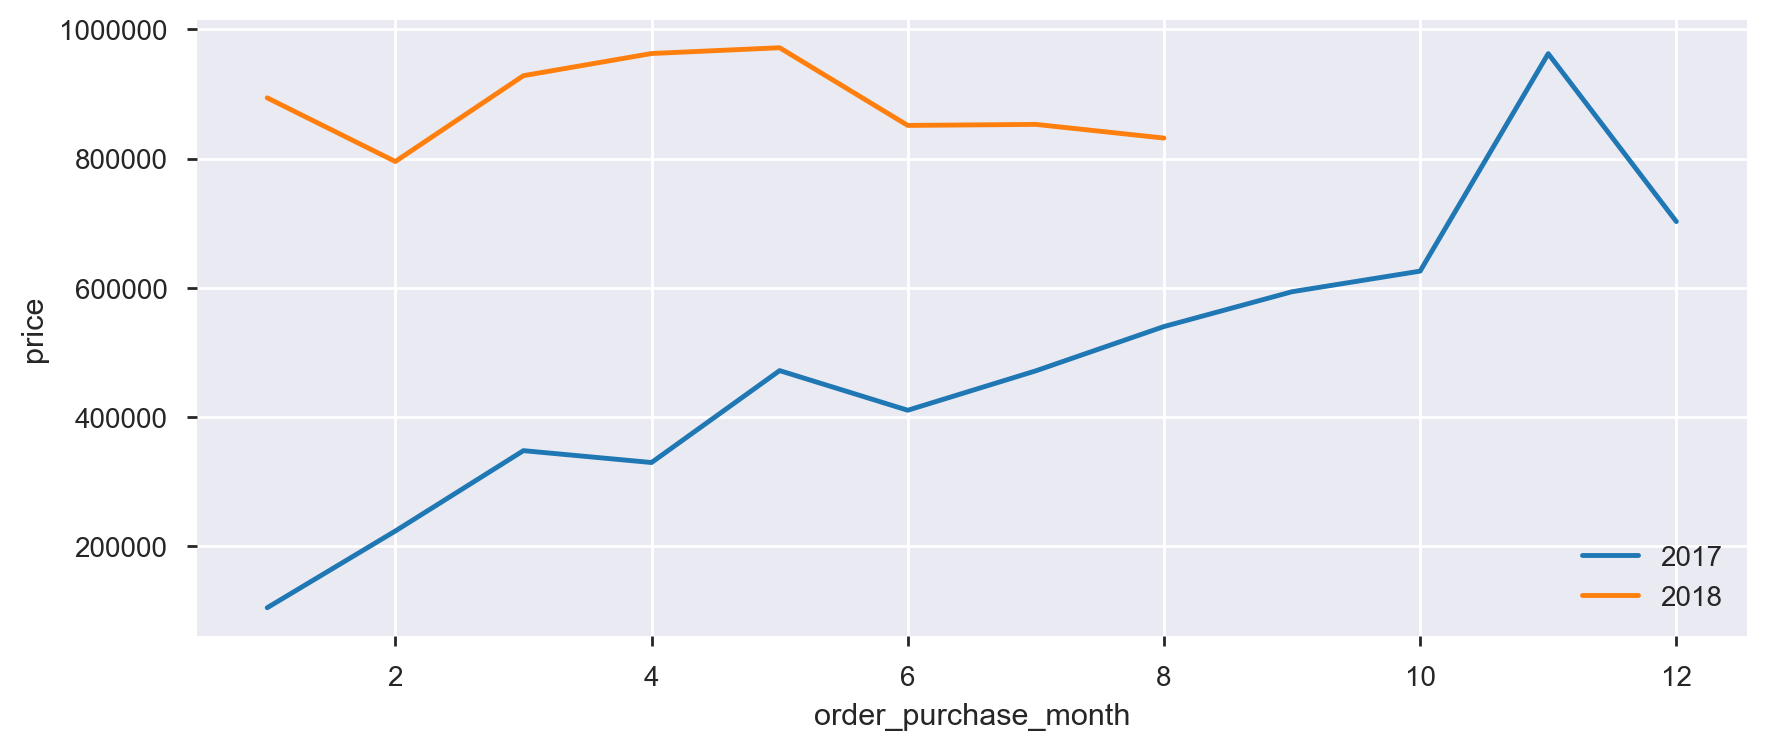

In [45]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.lineplot(x='order_purchase_month', y='price', data=sales_by_month.iloc[3:15,:], label='2017')
ax = sns.lineplot(x='order_purchase_month', y='price', 
                  data=sales_by_month.iloc[15:, :], label='2018')

* From the timeseries data we CAN see an overall trend in increase in purchases but it is hard to do much with this as the 2016 and 2018 data are both incomplete, it's hard to get seasonality data from this. The 2018 data also shows a slow in sales growth, indicating that the business may have been in the early growth stages and is now evening out

##### Given we have so much information regarding shipping, I would like to create some new columns from the time stamp variables to see if these have an affect on future purchaes and/or ratings. The following might be good varibales to have in my model:
* Time to courier from order
* Time to delivery from courier
* Overall shipping time
* Whether or not seller made shipping limit date
* Whether or not order was received within estimated delivery date

##### Creation of new columns in days

In [46]:
def days_between(columns, df=df):
    """ Takes a list of columns and a dataframe and returns the difference 
        between the two columns in days to one decimal place
        
        Parameters: 
        df
          pandas dataframe
        columns
          list of 2 columns in datetime64[ns] format
          
        Returns:
          pandas series of days in float64 dtype
    """
    new_col = df[columns[0]] - df[columns[1]]
    new_col = round(new_col.dt.total_seconds()/(60*60*24),ndigits=1)
    return new_col

In [47]:
df['days_to_customer'] = abs(days_between(columns = ['order_delivered_customer_date','order_delivered_carrier_date']))
df['days_to_carrier'] = abs(days_between(columns = ['order_purchase_timestamp','order_delivered_carrier_date']))
df['overall_shipping_time'] = abs(days_between(columns = ['order_purchase_timestamp','order_delivered_customer_date']))

In [48]:
def on_time(expected, observed, df=df):
    """ Takes two date columns, observed and expected, and determines if the observed
        date adheres to the expected date
        
        Parameters:
        df
          pandas dataframe
        expected
          series in datetime64[ns] format describing expected date
        observed
          series in datetime64[ns] format describing observed date
        
        Returns:
          pandas series of boolean type describing if the expectation was met
          1 is yes, 0 is no
    """ 
    col_list = [expected, observed]
    days = days_between(columns=col_list)
    
    final_list = []
    for day in days:
        if day > 0:
            final_list.append(1)
        else:
            final_list.append(0)
    return final_list

In [49]:
df['shipped_on_time'] = on_time(expected = 'shipping_limit_date', observed = 'order_delivered_carrier_date')

In [50]:
df['delivered_on_time'] = on_time(expected = 'order_estimated_delivery_date', observed = 'order_delivered_customer_date')

##### Now lets take a look at the stats of these newly created columns

In [51]:
df.describe().T

count         mean          std      min  \
price                     107272.0   120.370412   182.529337     0.85   
freight_value             107272.0    19.994156    15.756007     0.00   
product_name_len          107272.0    48.799118    10.009362     5.00   
product_description_len   107272.0   789.208647   652.286343     4.00   
product_photos_qty        107272.0     2.216058     1.725992     1.00   
product_weight_g          107272.0  2097.386103  3746.359358     0.00   
product_length_cm         107272.0    30.179655    16.163498     7.00   
product_height_cm         107272.0    16.601219    13.441674     2.00   
product_width_cm          107272.0    23.011392    11.694892     6.00   
payment_installments      107272.0     2.977935     2.782918     0.00   
payment_value             107272.0   179.928471   272.598967     9.59   
review_score              107272.0     4.073272     1.353423     1.00   
order_purchase_year       107272.0  2017.548102     0.503401  2016.00   
order_purchase_month      107272.0     6.038752     3.221015     1.00   
order_purchase_dayofweek  107272.0     2.743176     1.962890     0.00   
days_to_customer          107272.0     9.182746     8.619295     0.00   
days_to_carrier           107272.0     3.272328     3.611070     0.00   
overall_shipping_time     107272.0    12.449289     9.431125     0.50   
shipped_on_time           107272.0     0.902416     0.296752     0.00   
delivered_on_time         107272.0     0.920054     0.271211     0.00   

                              25%      50%      75%       max  
price                       39.90    74.90   134.90   6735.00  
freight_value               13.08    16.31    21.18    409.68  
product_name_len            42.00    52.00    57.00     76.00  
product_description_len    348.00   603.00   991.00   3992.00  
product_photos_qty           1.00     1.00     3.00     20.00  
product_weight_g           300.00   700.00  1800.00  40425.00  
product_length_cm           18.00    25.00    38.00    105.00  
product_height_cm            8.00    13.00    20.00    105.00  
product_width_cm            15.00    20.00    30.00    118.00  
payment_installments         1.00     2.00     4.00     24.00  
payment_value               65.71   114.43   195.50  13664.08  
review_score                 4.00     5.00     5.00      5.00  
order_purchase_year       2017.00  2018.00  2018.00   2018.00  
order_purchase_month         3.00     6.00     8.00     12.00  
order_purchase_dayofweek     1.00     3.00     4.00      6.00  
days_to_customer             4.10     7.10    11.90    205.20  
days_to_carrier              1.10     2.20     4.10    171.20  
overall_shipping_time        6.70    10.20    15.50    209.60  
shipped_on_time              1.00     1.00     1.00      1.00  
delivered_on_time            1.00     1.00     1.00      1.00

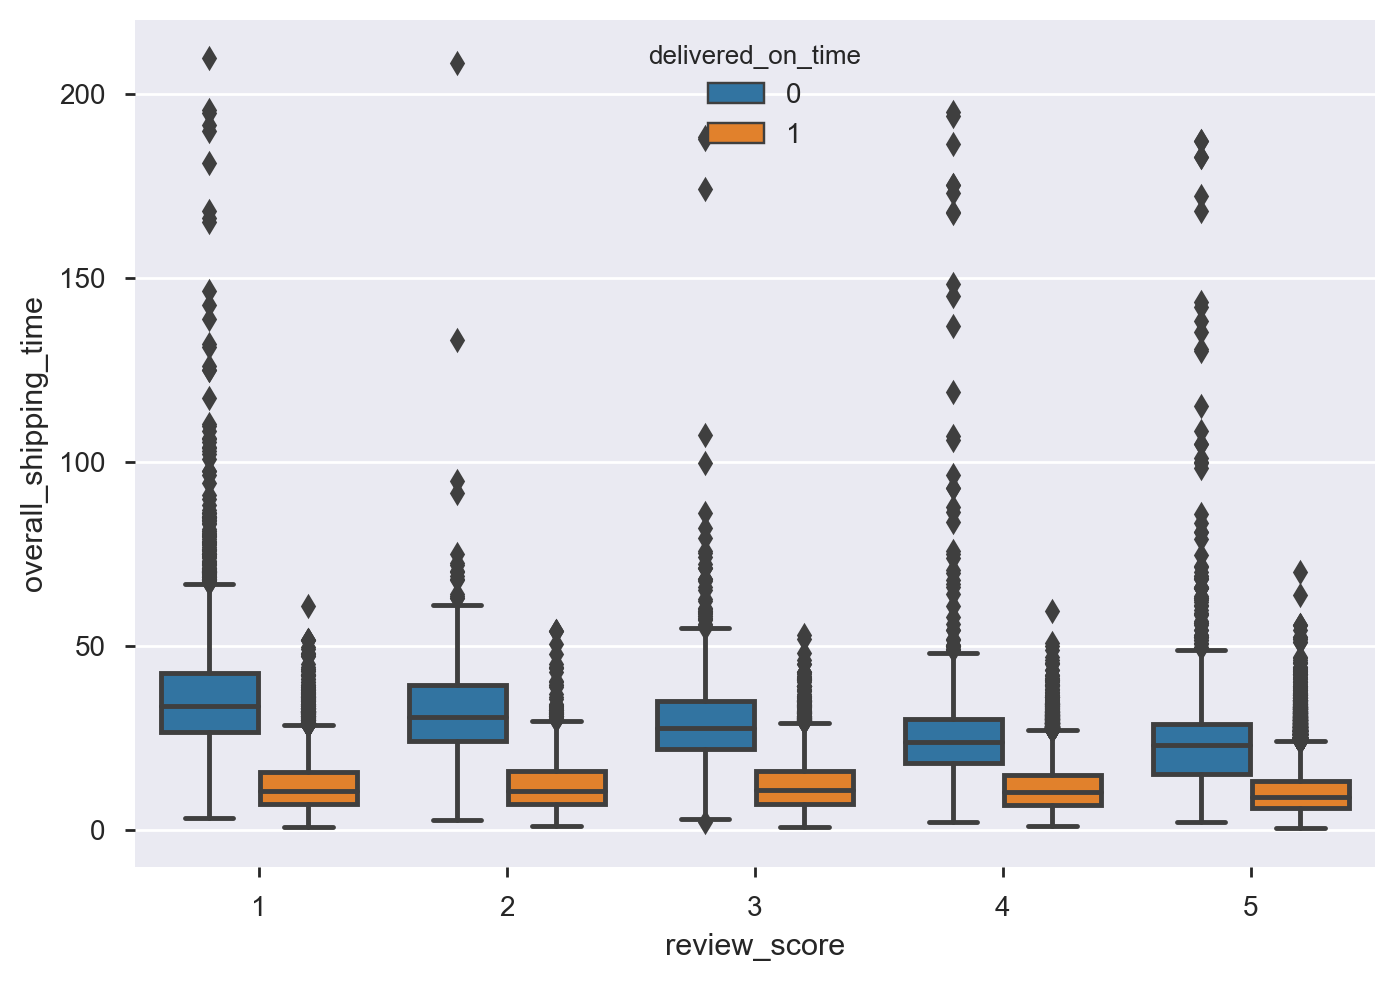

In [52]:
sns.boxplot(y='overall_shipping_time',x='review_score', data = df, hue='delivered_on_time')

* From this we can see that if an order is delivered on time it doesn't have too much affect on the review score. However, if a shipment is NOT delivered on time, the longer it takes to be delivered, the more likely it is to be given a low review score

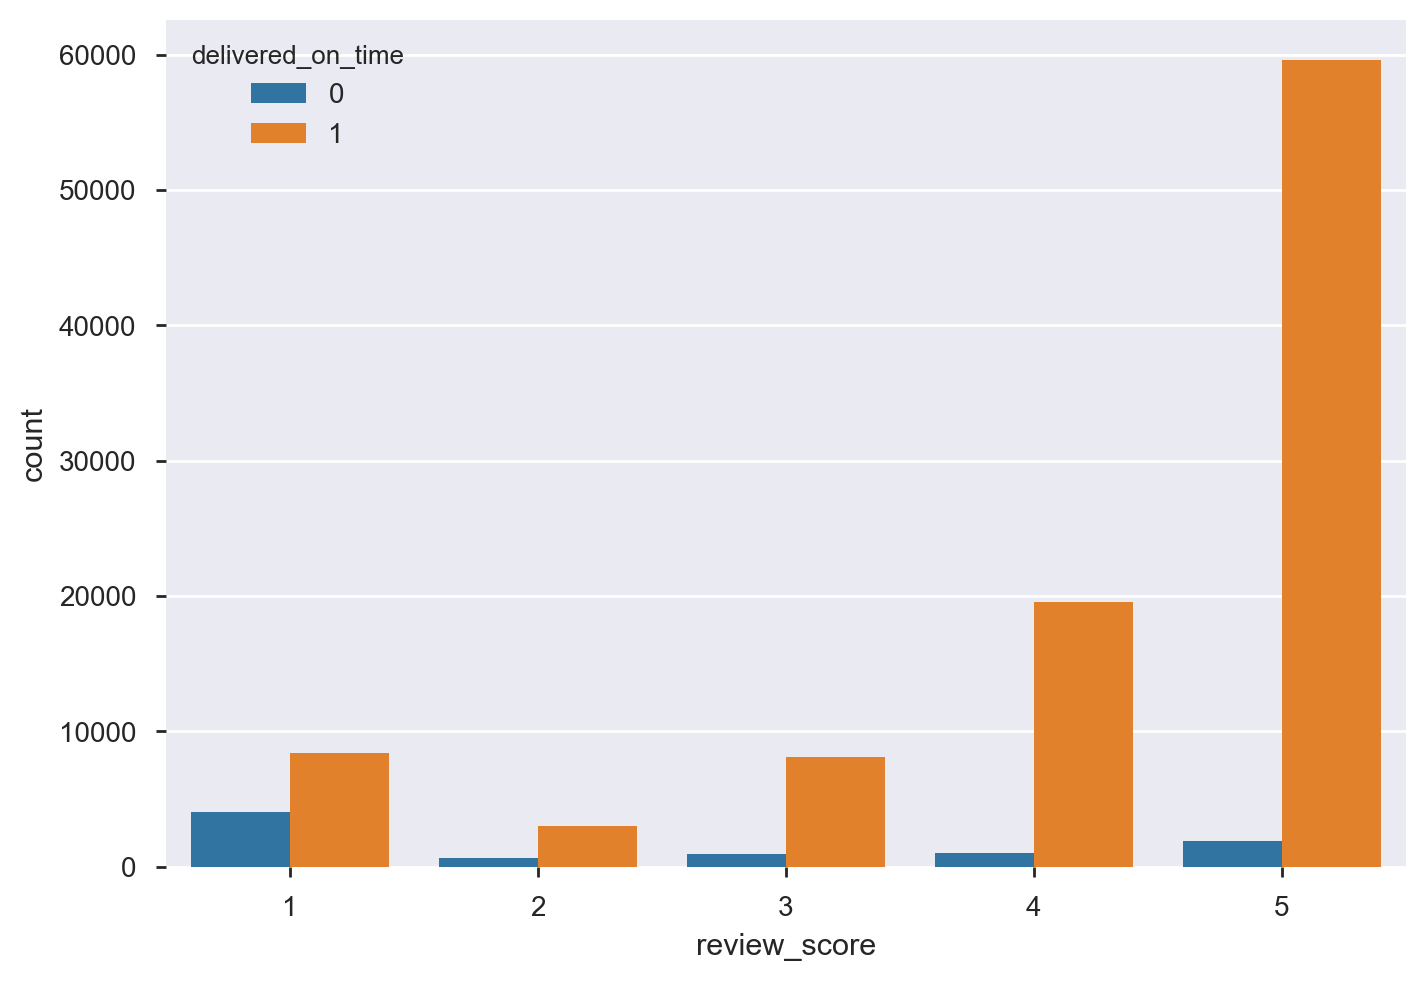

In [53]:
sns.countplot(x="review_score", hue="delivered_on_time", data=df)

##### Separate out delivered on time and then look at the box plot again

In [54]:
 on_time_df = df[df['delivered_on_time'] == 1]

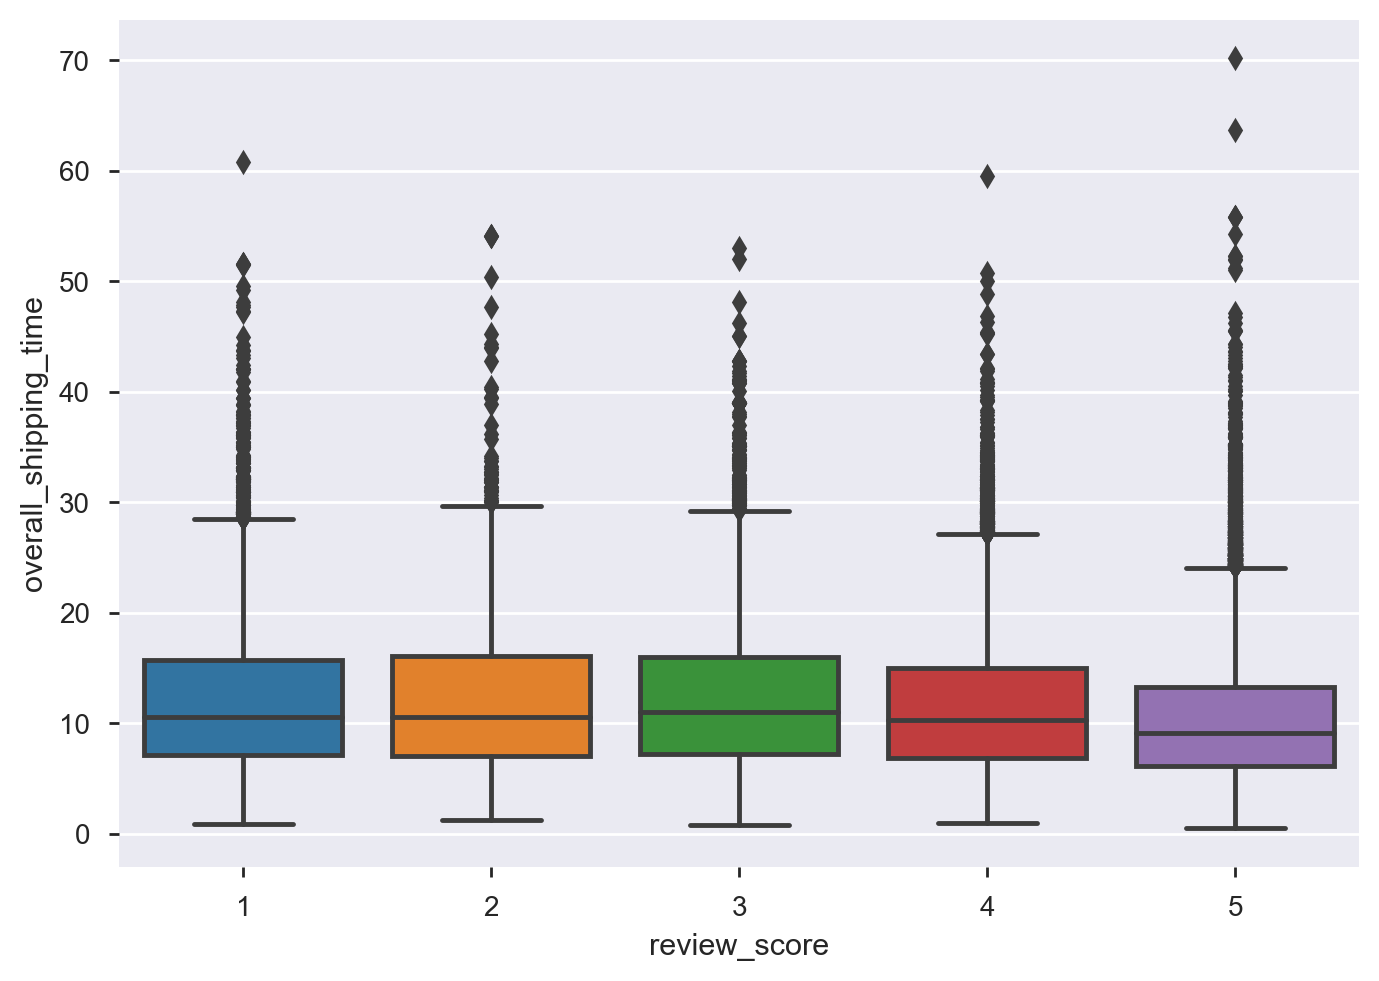

In [55]:
sns.boxplot(y='overall_shipping_time',x='review_score', data = on_time_df)

* Once we have separated out the orders that were delivered on time, it clear that shipping time *does* have an affect on the review score, but not as much as I would expect. This leads me to believe that the review score for the orders delivered on time is more likely to be based on the products quality

### Explore Categorical Variables

In [56]:
data_dictionary[data_dictionary['Variable Type'] == 'categorical']

Variable Datatype  \
0   order_id                         object   
1   product_id                       object   
2   seller_id                        object   
17  product_category_name_english    object   
18  seller_city                      object   
19  seller_state                     object   
20  customer_unique_id               object   
21  customer_zip_code_prefix         object   
22  customer_city                    object   
23  customer_state                   object   
24  payment_type                     object   

                                      Description Variable Type  \
0                 unique id number for each order   categorical   
1               unique id number for each product   categorical   
2                unique id number for each seller   categorical   
17    product category name translated to english   categorical   
18                           seller city location   categorical   
19                          seller state location   categorical   
20             unique id number for each customer   categorical   
21  zip code prefix of customers delivery address   categorical   
22                         customer city location   categorical   
23                        customer state location   categorical   
24       method of payment chosen by the customer   categorical   

                               Example  
0   '00010242fe8c5a6d1ba2dd792cb16214'  
1   '4244733e06e7ecb4970a6e2683c13e61'  
2   '48436dade18ac8b2bce089ec2a041202'  
17                        'cool_stuff'  
18                     'volta redonda'  
19                                'SP'  
20  '871766c5855e863f6eccc05f988b23cb'  
21                               28013  
22             'campos dos goytacazes'  
23                                'RJ'  
24                       'credit_card'

In [57]:
print("Total number of products in the database:",df['product_id'].nunique())
print("Total number of customers:",df['customer_unique_id'].nunique())
print("Total number of units ordered:", df.shape[0])

Total number of products in the database: 31332
Total number of customers: 91593
Total number of units ordered: 107272


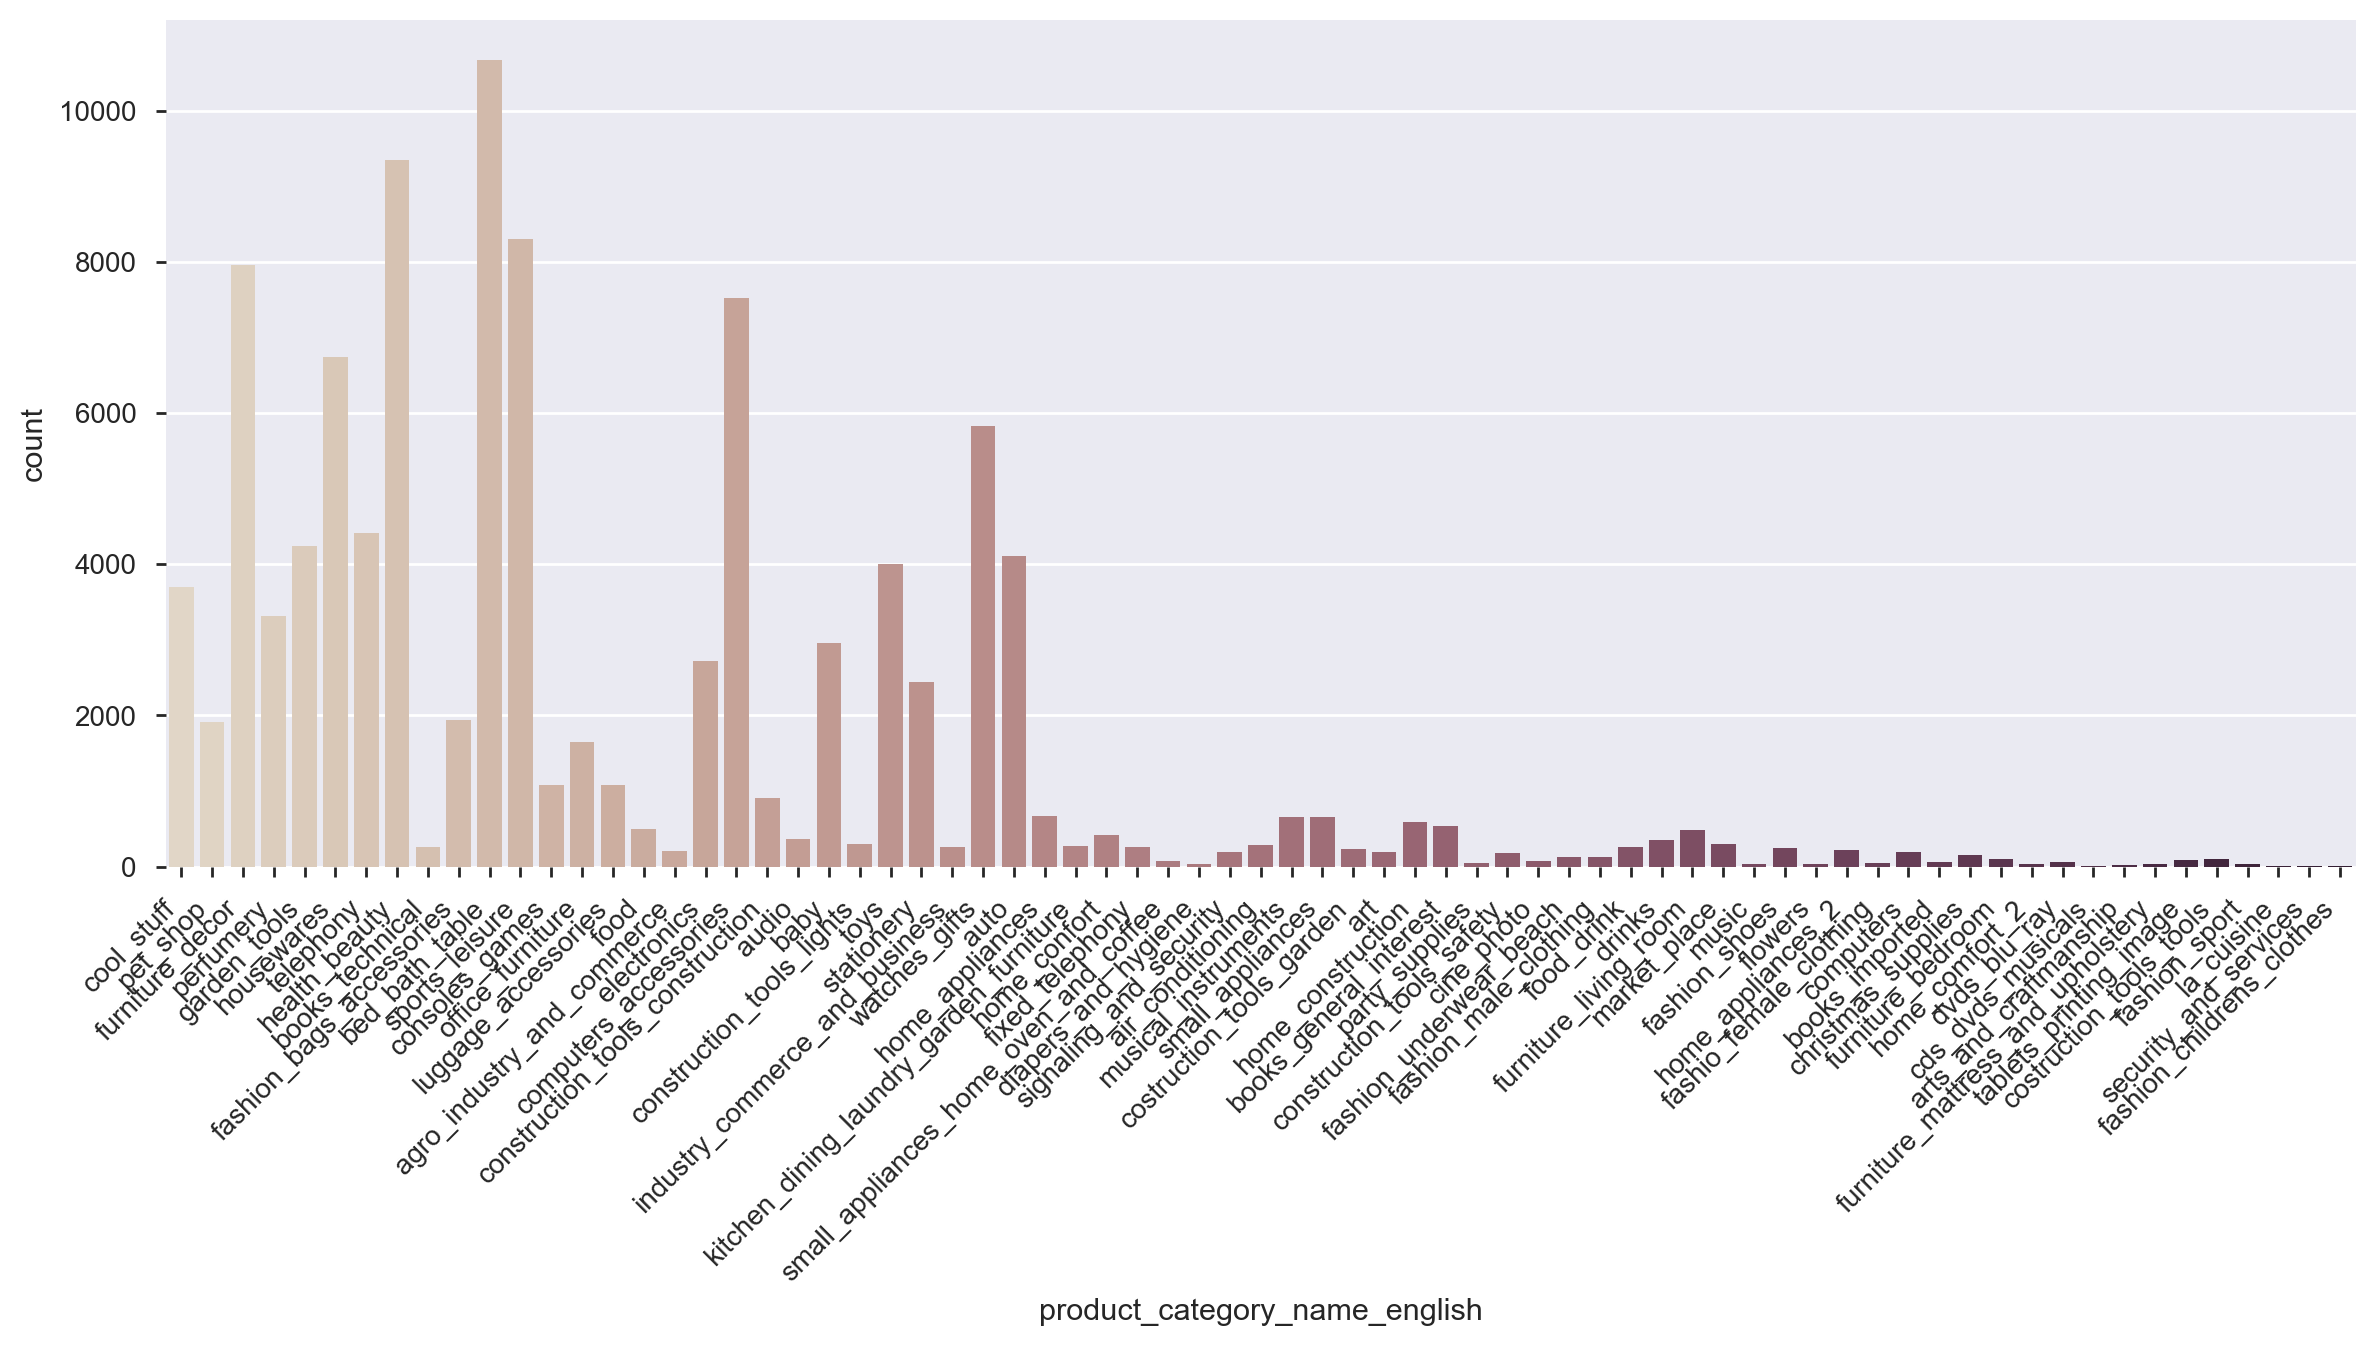

In [58]:
sns.catplot(data=df, x='product_category_name_english', kind="count", palette="ch:.25",
            aspect=2.5).set_xticklabels(rotation=45, horizontalalignment='right')

In [59]:
df.product_category_name_english.value_counts().sort_values()

security_and_services                        2
fashion_childrens_clothes                    7
la_cuisine                                  13
cds_dvds_musicals                           14
arts_and_craftmanship                       24
fashion_sport                               28
home_comfort_2                              30
flowers                                     33
furniture_mattress_and_upholstery           35
diapers_and_hygiene                         37
music                                       38
party_supplies                              42
fashio_female_clothing                      44
books_imported                              57
dvds_blu_ray                                61
cine_photo                                  69
small_appliances_home_oven_and_coffee       72
tablets_printing_image                      83
costruction_tools_tools                    103
furniture_bedroom                          103
fashion_underwear_beach                    122
fashion_male_

##### There are too many categories and they are highly variant in purchases against each, so I will combine them into some more general ones

In [60]:
## New catogory lists
beauty = ['perfumery', 'health_beauty']

books = ['books_technical', 'books_general_interest', 'books_imported']

electronics_technology = ['telephony','electronics','computers_accessories','audio','air_conditioning',
                          'fixed_telephony','signaling_and_security','cine_photo','computers',
                          'tablets_printing_image','security_and_services']

entertainment = ['consoles_games','musical_instruments','music','dvds_blu_ray','cds_dvds_musicals']

fashion = ['fashion_bags_accessories','watches_gifts','fashion_underwear_beach','fashion_male_clothing',
           'fashion_shoes','fashio_female_clothing','fashion_sport','fashion_childrens_clothes']

food_grocery = ['food','diapers_and_hygiene','food_drink','drinks','market_place','la_cuisine']

furniture = ['furniture_decor','kitchen_dining_laundry_garden_furniture','furniture_living_room',
             'furniture_bedroom','furniture_mattress_and_upholstery']

garden_outdoor = ['garden_tools','agro_industry_and_commerce','construction_tools_construction',
                  'construction_tools_lights','costruction_tools_garden','home_construction',
                  'construction_tools_safety','costruction_tools_tools']

gifts_party = ['cool_stuff','party_supplies','christmas_supplies']

home_appliances = ['housewares','bed_bath_table','luggage_accessories','home_appliances','home_confort',
                   'small_appliances_home_oven_and_coffee','small_appliances','art','flowers','home_appliances_2',
                   'home_comfort_2','arts_and_craftmanship']

office_stationery = ['office_furniture','stationery','industry_commerce_and_business']

pets = ['pet_shop']

sports = ['sports_leisure']

toys = ['toys']

baby = ['baby']

auto = ['auto']

#categories staying as they are: toys, baby, auto

##### Creation of a dictionary to iterate over

In [61]:
cats = {'beauty': beauty, 'books': books, 'electronics_technology': electronics_technology,
        'entertainment': entertainment, 'fashion': fashion, 'food_grocery': food_grocery,
        'furniture': furniture, 'garden_outdoor': garden_outdoor, 'gifts_party': gifts_party,
        'home_appliances': home_appliances, 'office_stationery': office_stationery, 'pets': pets,
        'sports': sports, 'toys': toys, 'baby': baby, 'auto': auto}

In [62]:
def categorise(data):
    for k,v in cats.items():
        if data in v:
            return k    

##### Mapping the new categories to their own column

In [63]:
df['category'] = df.product_category_name_english.map(categorise)

In [64]:
df.category.value_counts()

home_appliances           20819
electronics_technology    16112
beauty                    12667
furniture                  8852
fashion                    8350
sports                     8301
garden_outdoor             6759
office_stationery          4363
auto                       4113
toys                       4001
gifts_party                3894
baby                       2962
pets                       1917
entertainment              1847
food_grocery               1462
books                       853
Name: category, dtype: int64

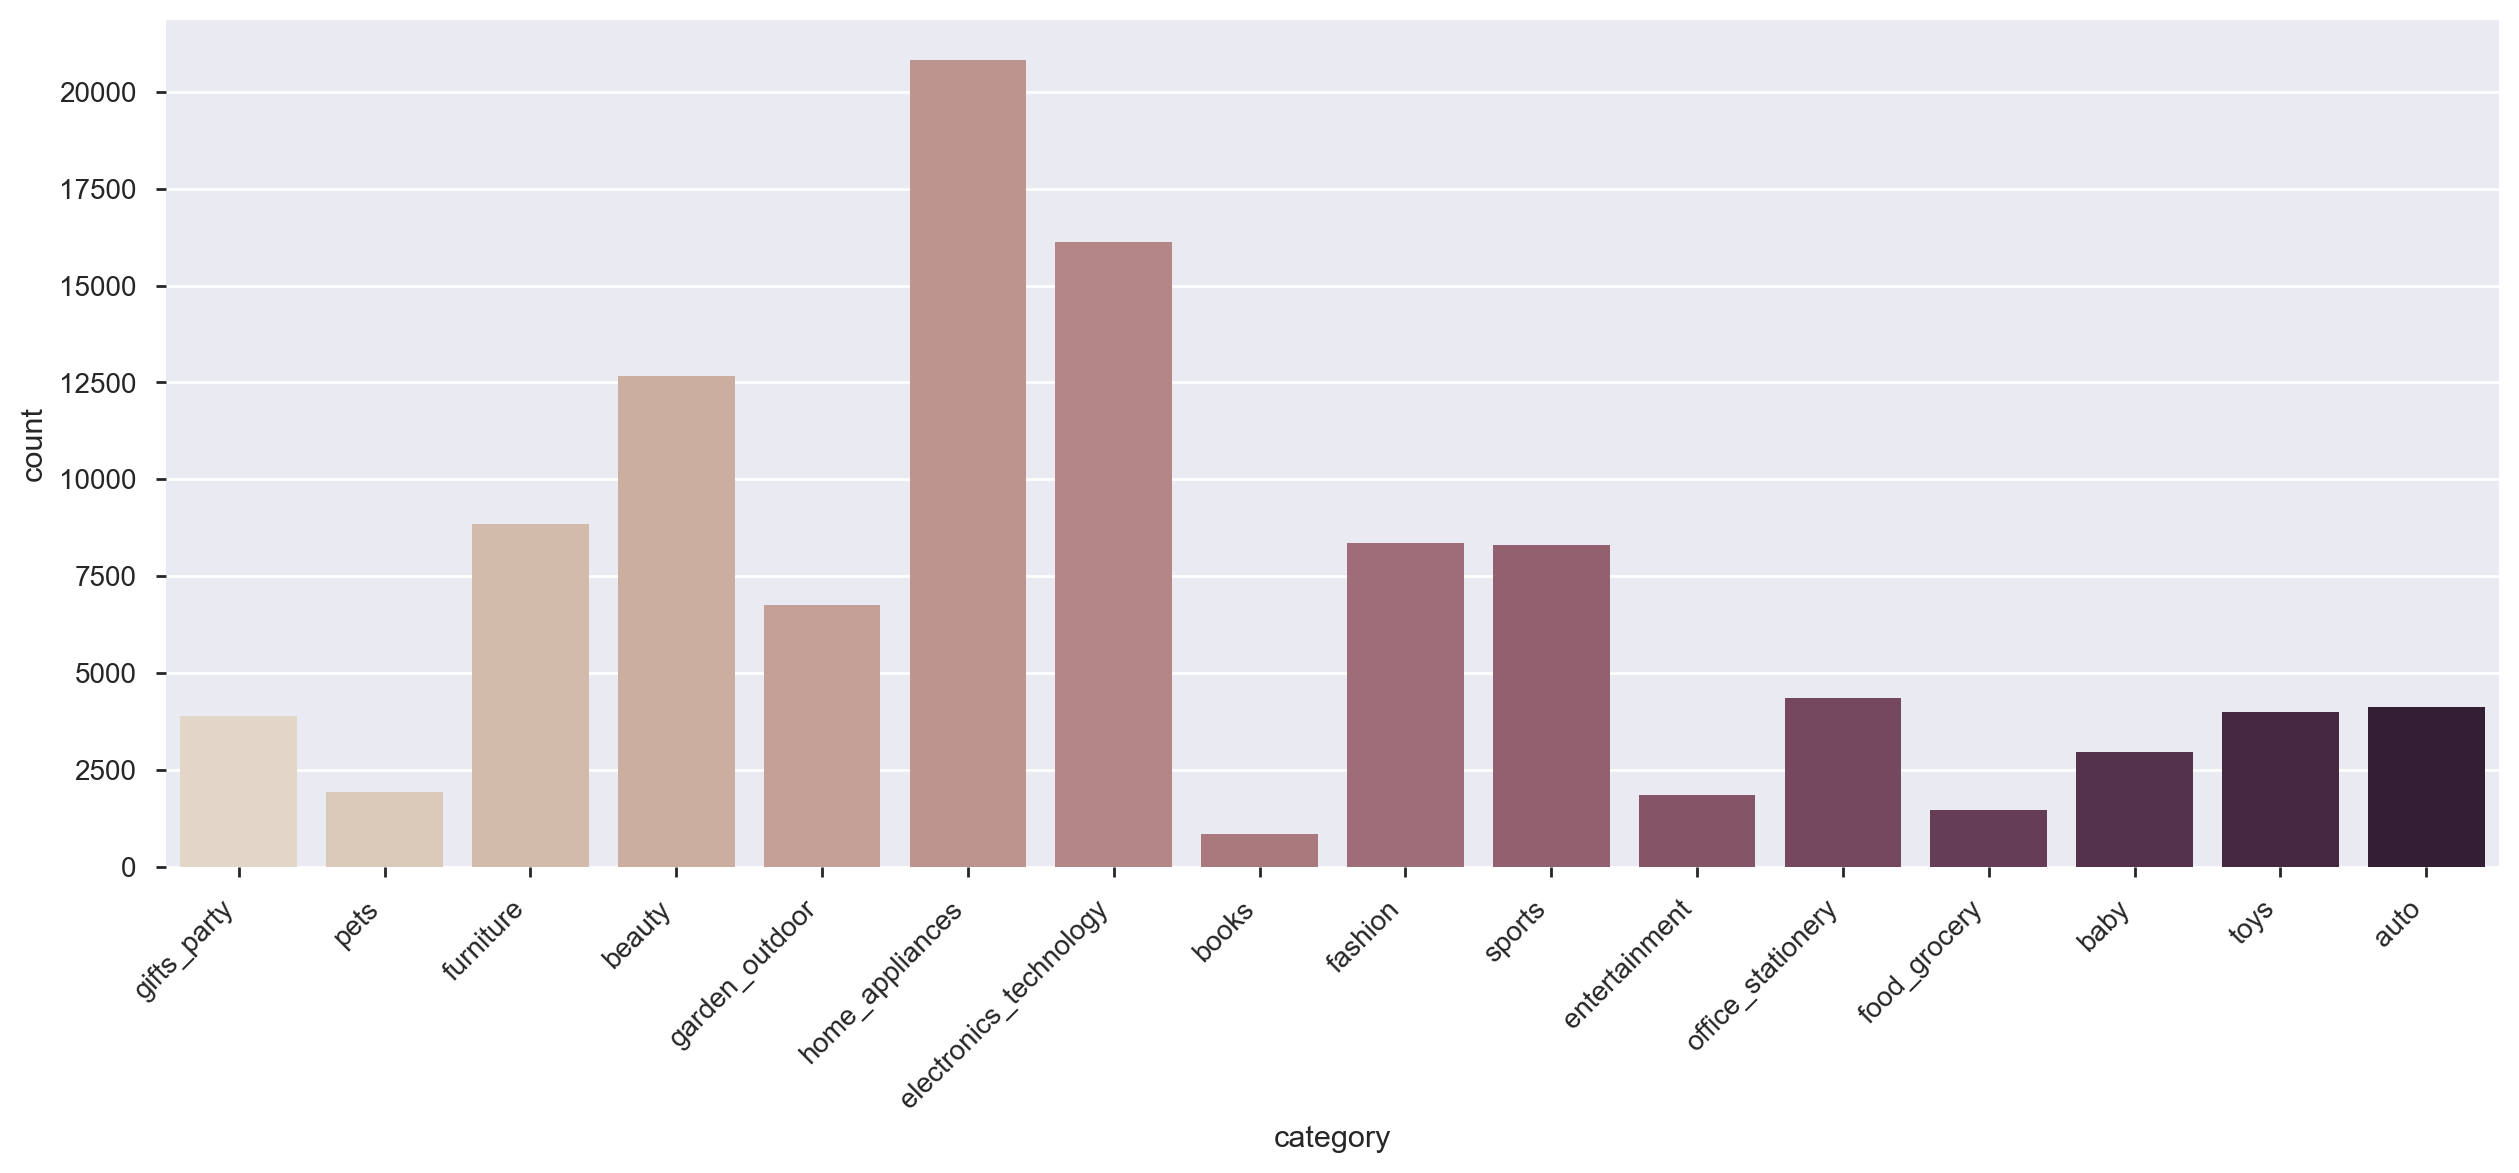

In [65]:
sns.catplot(data=df, x='category', kind="count", palette="ch:.25",aspect=2.5).set_xticklabels(rotation=45, horizontalalignment='right')

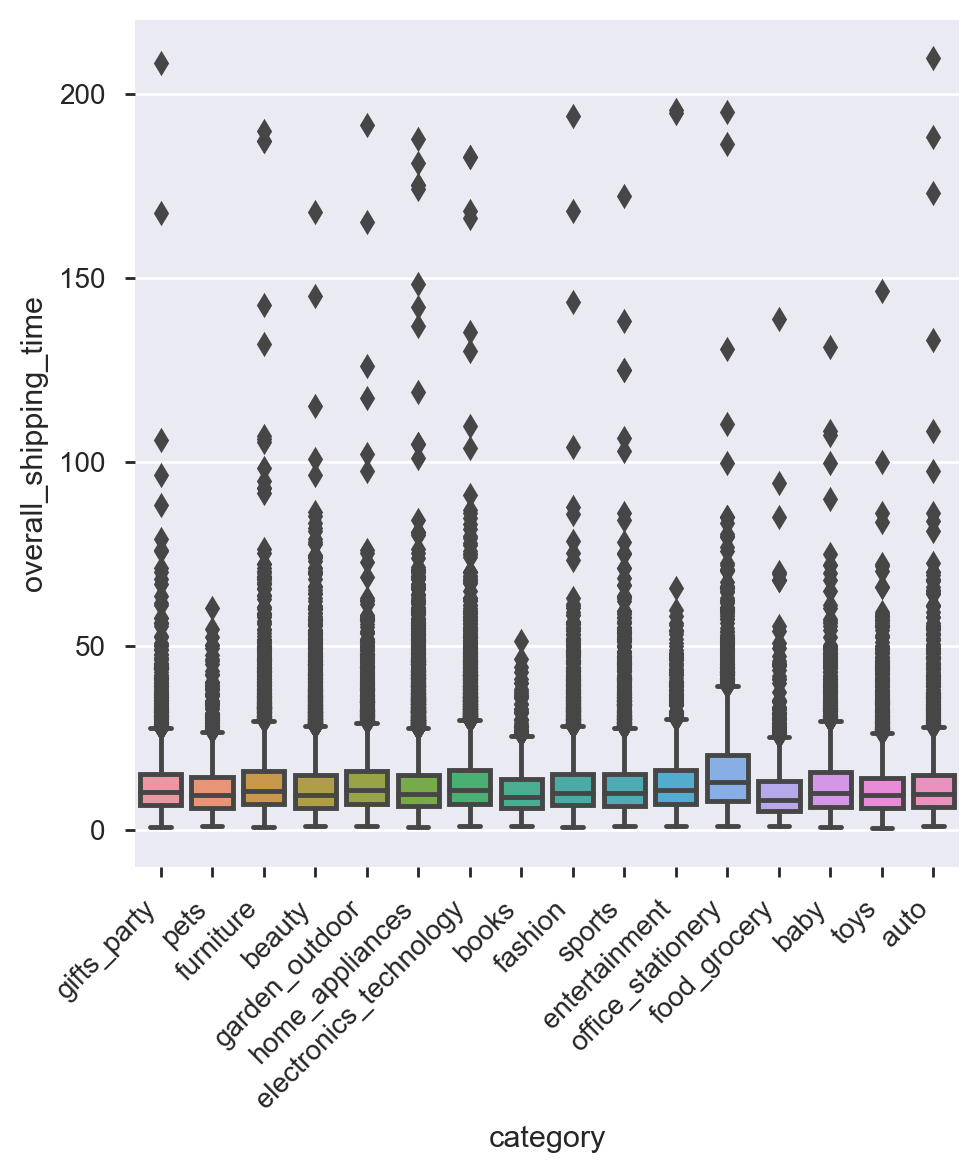

In [66]:
sns.catplot(data=df, kind = 'box', x='category', y='overall_shipping_time').set_xticklabels(rotation=45, horizontalalignment='right')

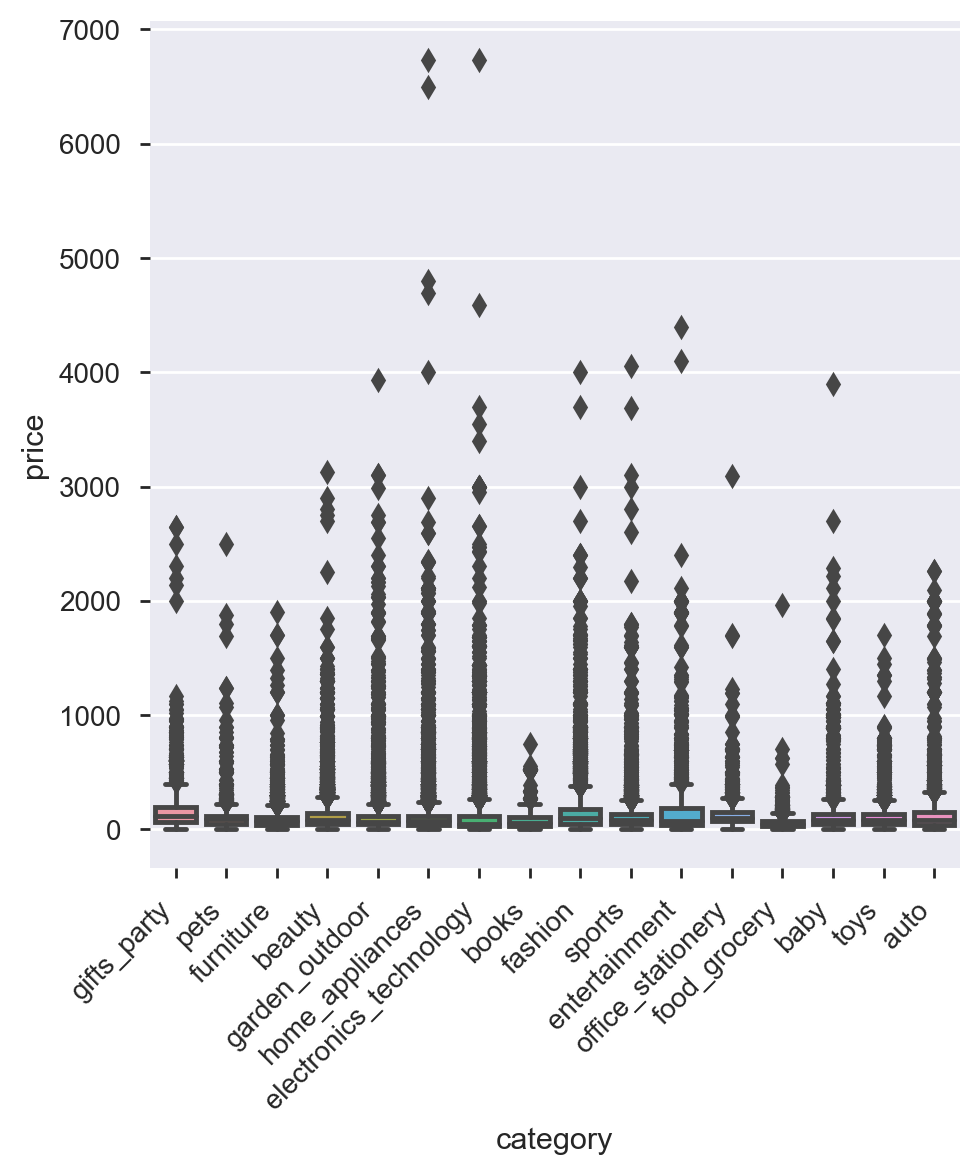

In [67]:
sns.catplot(data=df, kind = 'box', x='category', y='price').set_xticklabels(rotation=45, horizontalalignment='right')

##### Exploration of products and customers

In [68]:
col_counts = df['product_id'].value_counts()
top_100_prod = col_counts[0:101].index.to_list()

In [69]:
top_100_df = df[df['product_id'].isin(top_100_prod)]

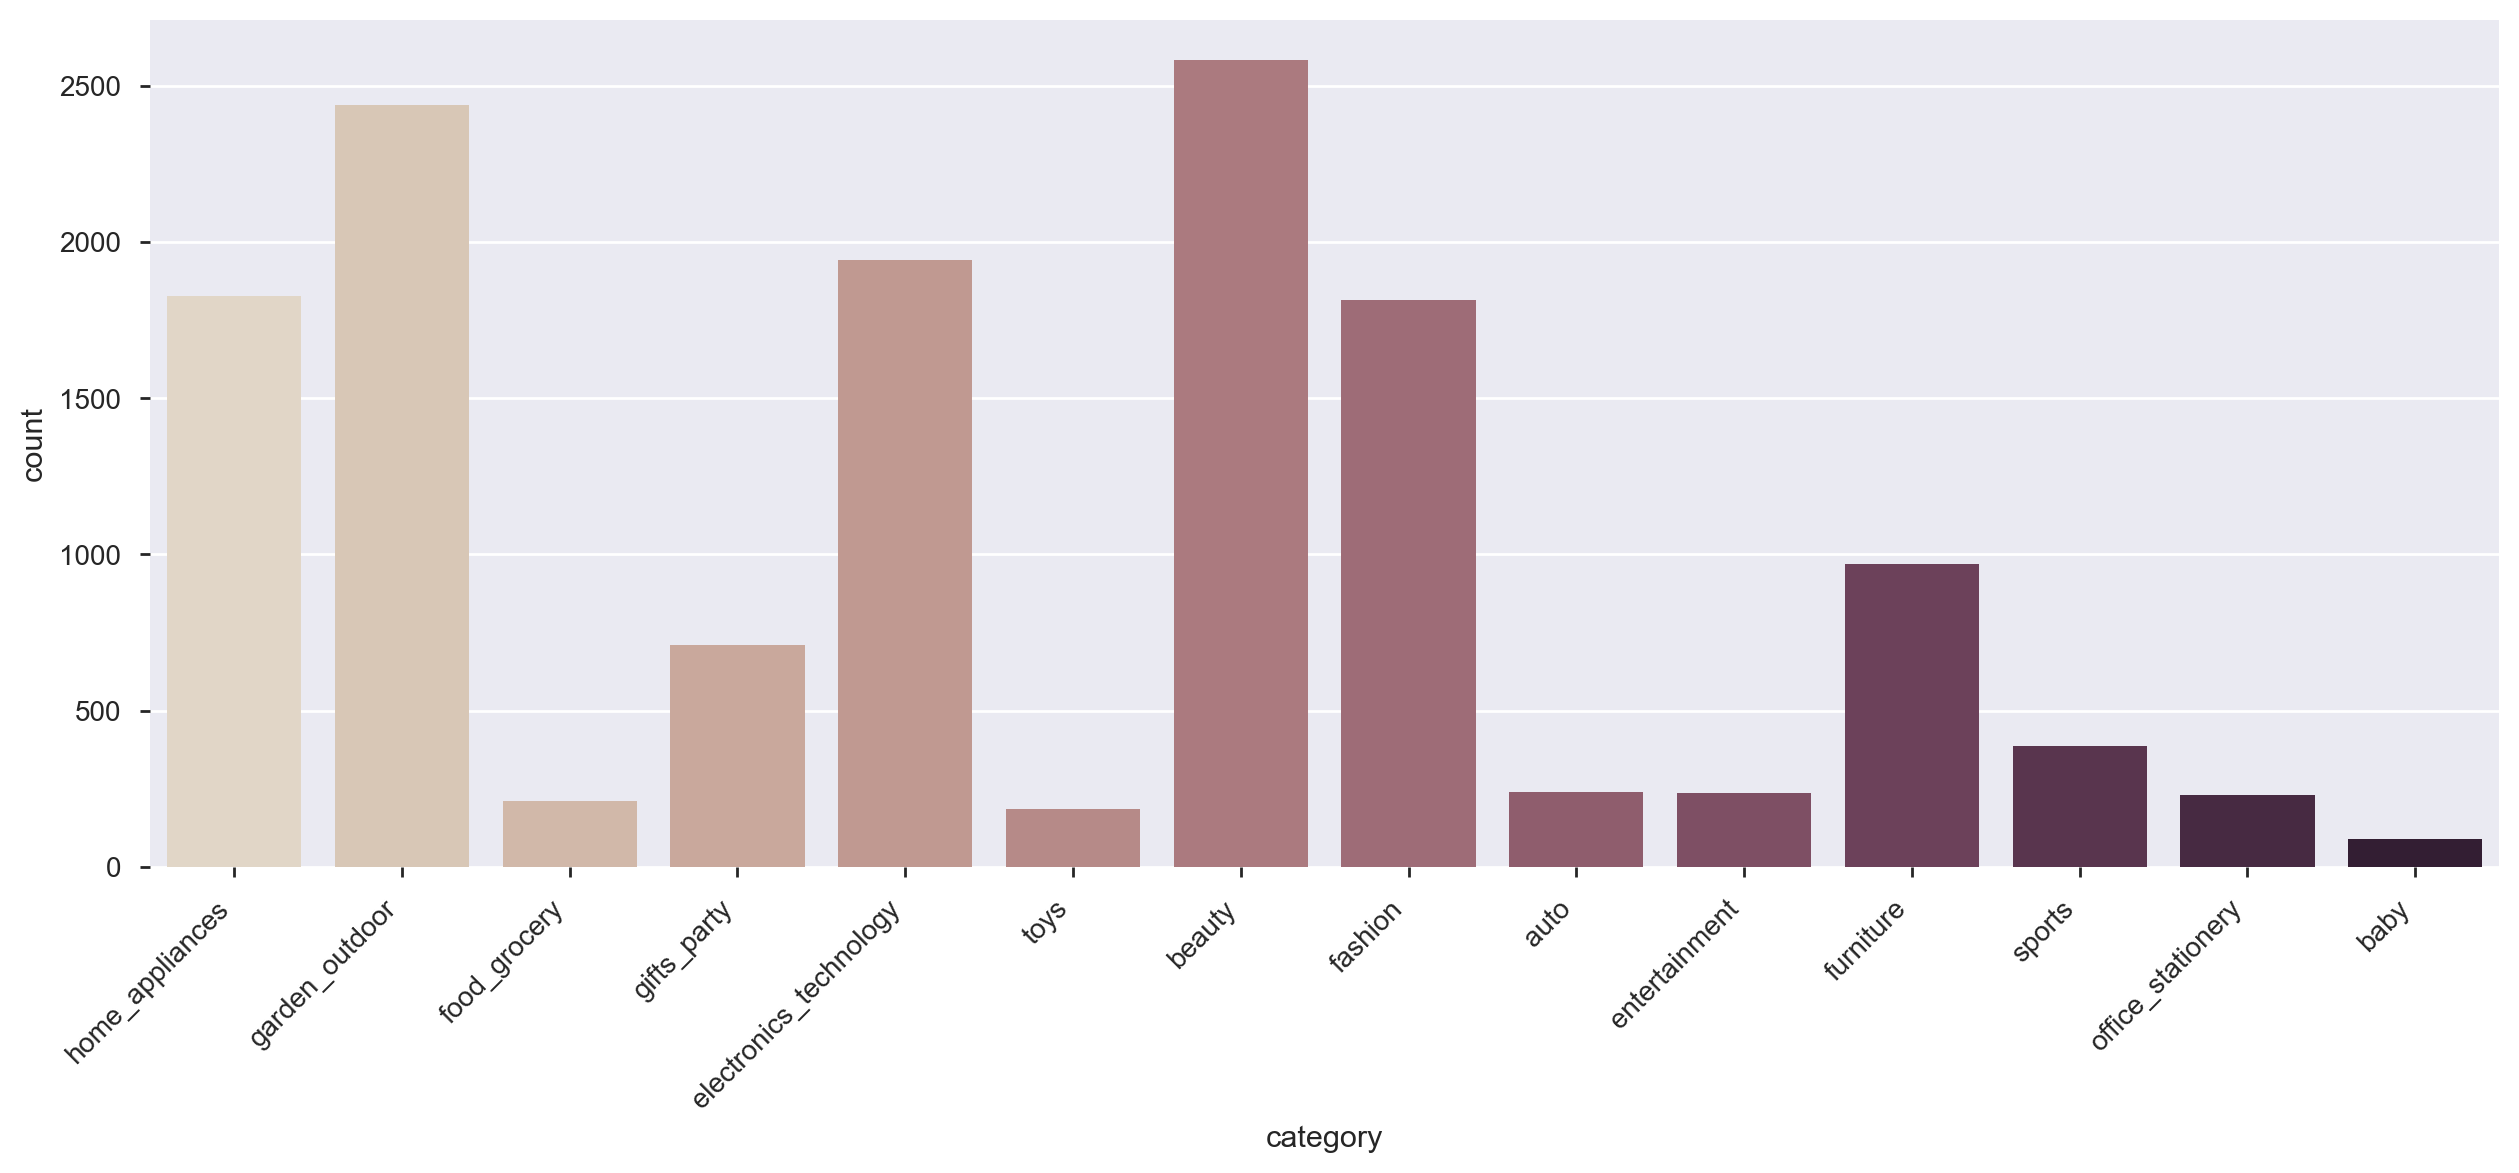

In [70]:
sns.catplot(data=top_100_df, x='category', kind="count", palette="ch:.25",aspect=2.5).set_xticklabels(rotation=45, horizontalalignment='right')

In [71]:
count = 0
for i in range(1,10):
    col_vc = df['product_id'].value_counts()
    duplicates = len(col_vc[col_vc == i])
    count += duplicates
    print("Number of products sold {} units:".format(i), duplicates)
print("Total number of products sold less than 10 times:", count)    

Number of products sold 1 units: 17242
Number of products sold 2 units: 5501
Number of products sold 3 units: 2523
Number of products sold 4 units: 1445
Number of products sold 5 units: 947
Number of products sold 6 units: 701
Number of products sold 7 units: 489
Number of products sold 8 units: 360
Number of products sold 9 units: 283
Total number of products sold less than 10 times: 29491


* In order to be able to do content based filtering, may need to drop some of the data with smaller units purchased. Considering there are just under 30,000 products ordered less than 10 times, if these were dropped, it would still leave 70% of the data left over

In [72]:
col_vc = df['customer_unique_id'].value_counts()
duplicates = col_vc[col_vc>5]

Text(0.5, 1.0, 'Customers with more than 5 sales')

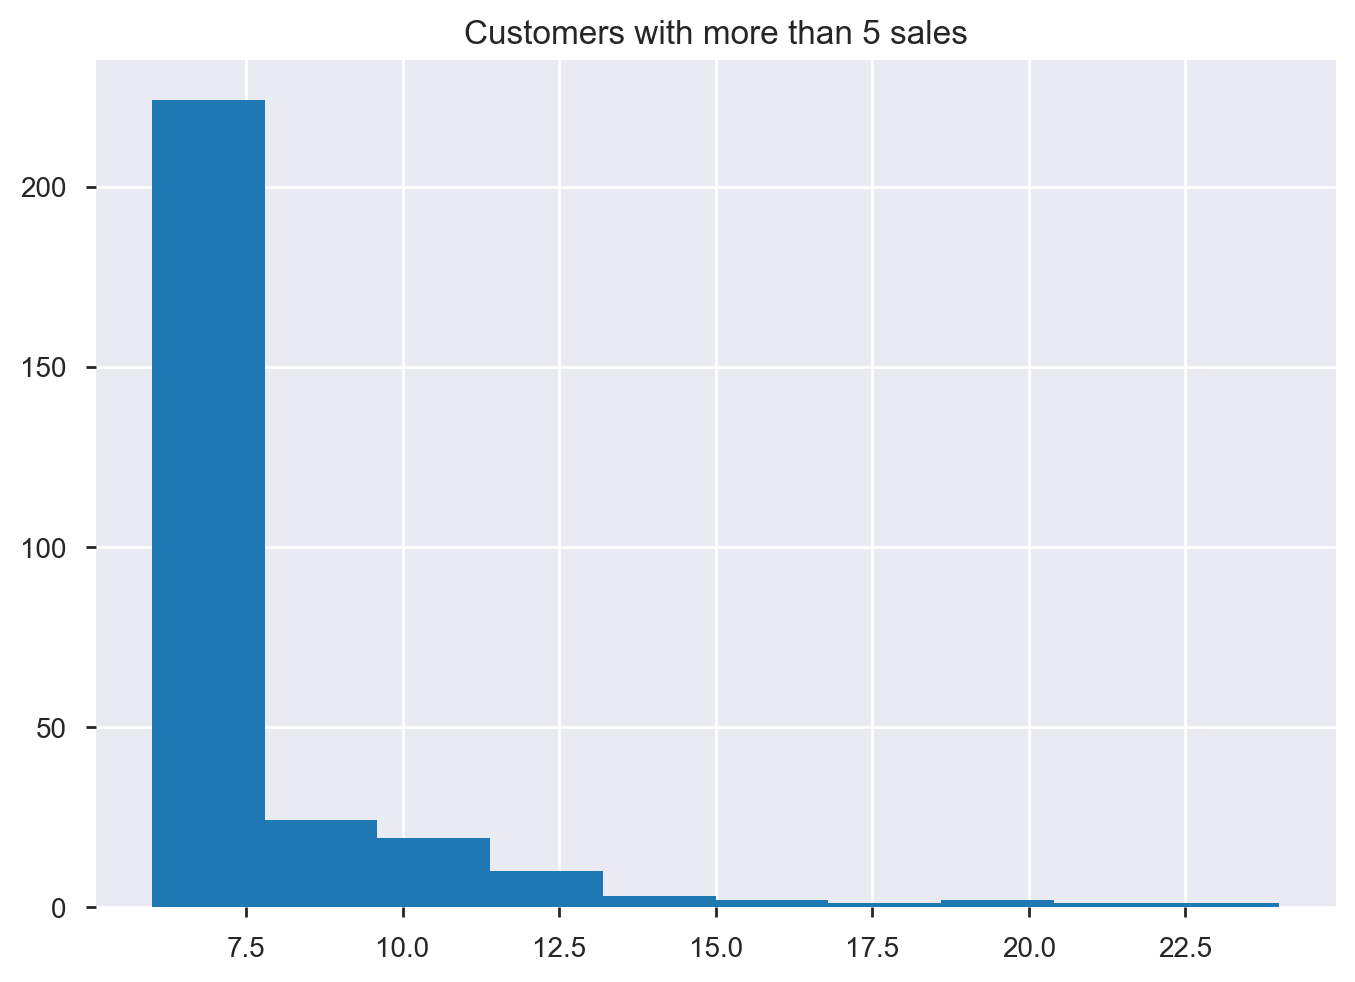

In [73]:
duplicates.hist()
plt.title("Customers with more than 5 sales")

In [74]:
order_count = 0
for i in range(1,10):
    col_vc = df['customer_unique_id'].value_counts()
    duplicates = len(col_vc[col_vc == i])
    order_count += duplicates
    print("Customers who ordered {} items:".format(i), duplicates)
print("Total customers who ordered less than 10 items:", order_count)  

Customers who ordered 1 items: 80743
Customers who ordered 2 items: 8270
Customers who ordered 3 items: 1493
Customers who ordered 4 items: 572
Customers who ordered 5 items: 228
Customers who ordered 6 items: 184
Customers who ordered 7 items: 40
Customers who ordered 8 items: 13
Customers who ordered 9 items: 11
Total customers who ordered less than 10 items: 91554


* As ~ 80% of the customers have ordered only 1 item and ~ 90% of customers have ordered less than 10 items, it is not a good indicator that collaborative filtering will work here as we need repeat customer sales to be able to make that work well

In [75]:
## I want to look at whether the customers that have bought multiple items have bought the same products 
## repetatively or if they have all been in the same order, OR if they have bought unique items across separate orders

In [76]:
# use groupby customer id THEN product? or some kind of pivot table?

In [ ]:
## Make sure to look at distribution of sales by seller_

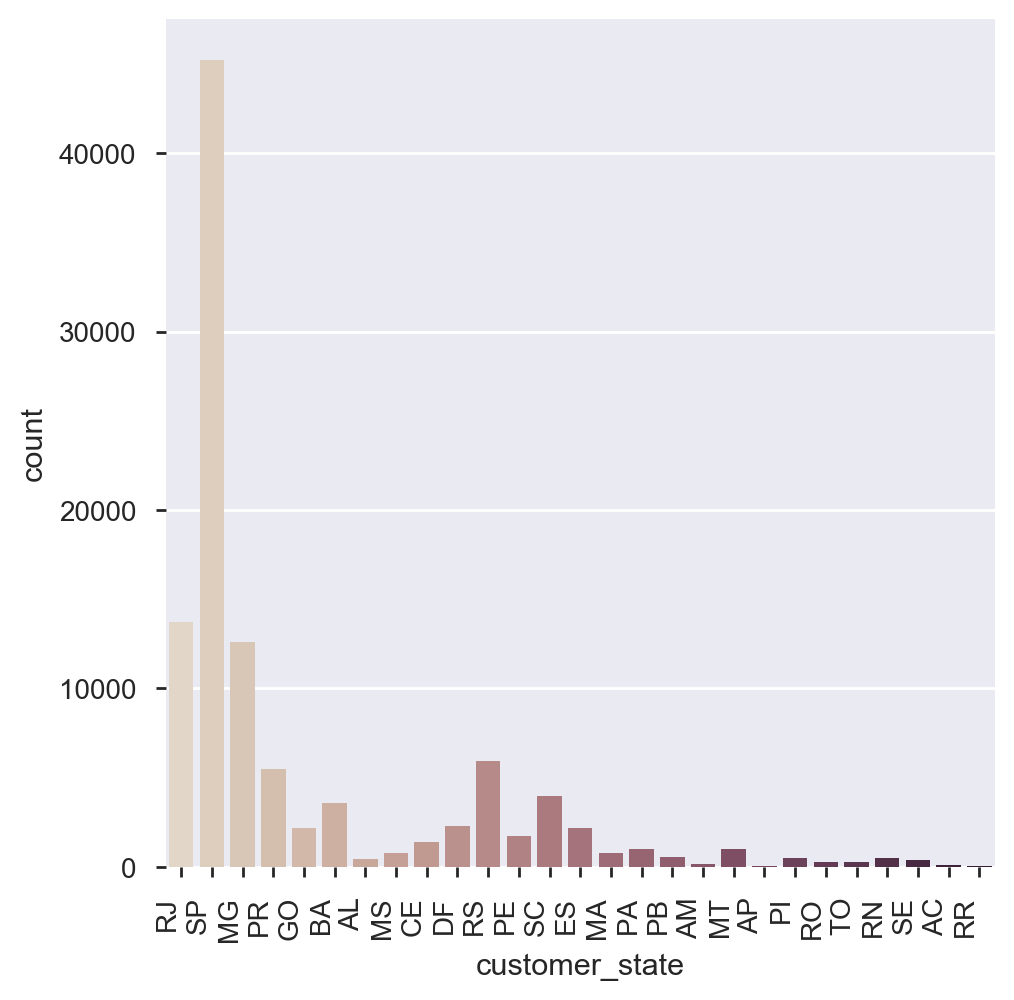

In [77]:
sns.catplot(data=df, x='customer_state', kind="count", palette="ch:.25").set_xticklabels(rotation=90, horizontalalignment='right')

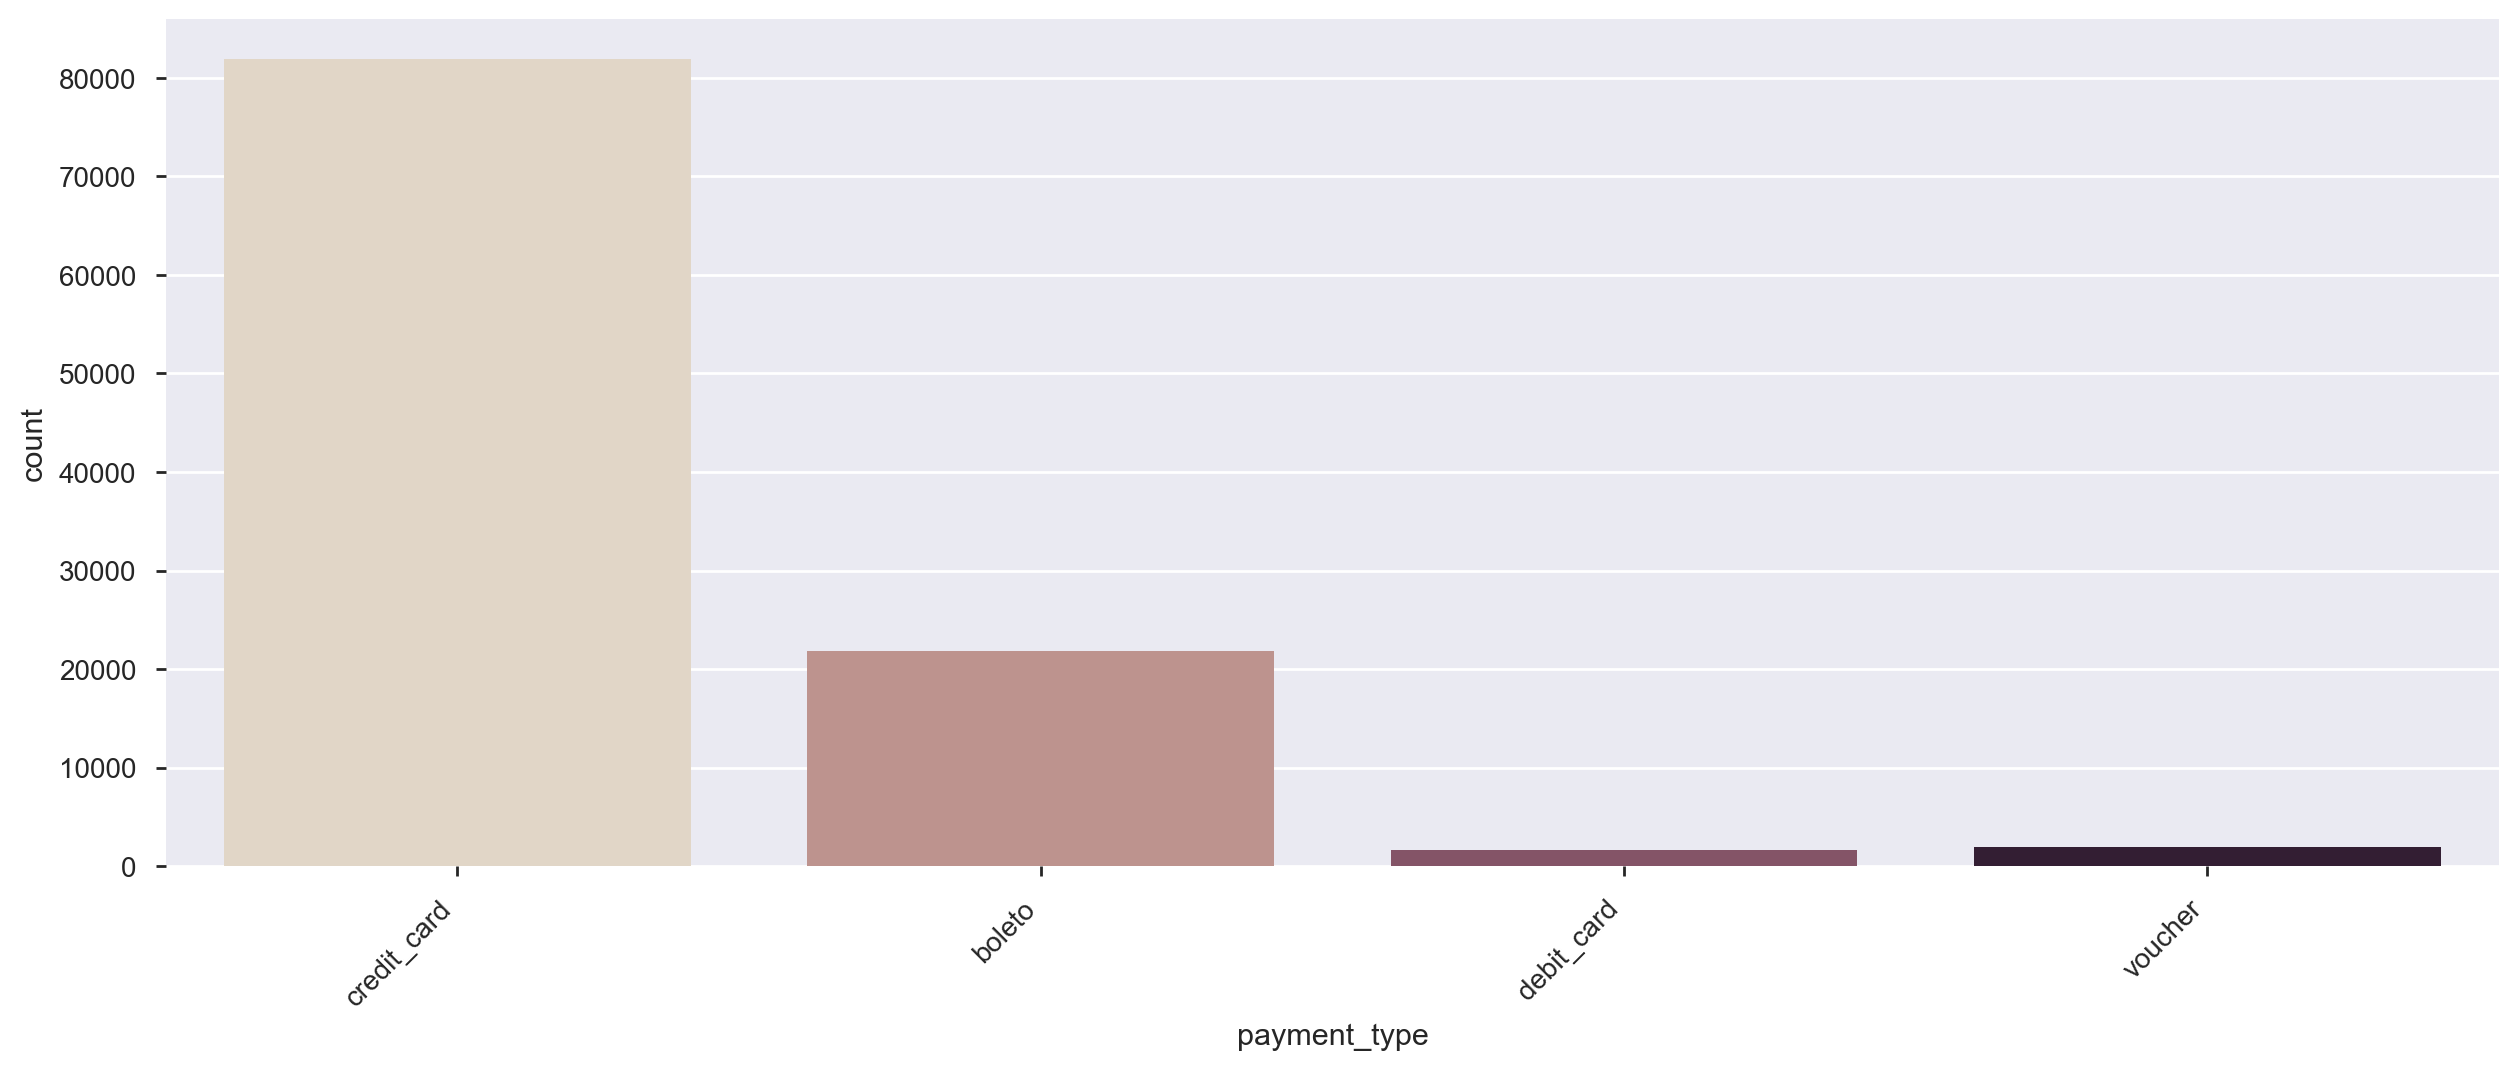

In [78]:
sns.catplot(data=df, x='payment_type', kind="count", palette="ch:.25",aspect=2.5).set_xticklabels(rotation=45, horizontalalignment='right')

* Considering credit card sales make up such a high proportion of the sales, there's probably not much to be gleaned from this

## Clustering
* I want to create a clustering model on this data so that I can see if there are clear clusters within the data that I may then be able to build a recommendation engine off.

In [79]:
from sklearn import cluster
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances